In [1]:
# %%
#Title: Double-CRISPR Knockout Simulation (DKOsim) - Mimicking Fong-2024 A549 Data
#Author: Yue Gu, Luis Leon Novelo, John Paul Shen, Glen Traver Hart
#Date: Sep 5, 2025
library(xtable)
library(MCMCpack)
library(entropy)
library(truncnorm)
library(ggtern)
library(gtools)
library(dplyr)
library(plyr)
library(doParallel)
library(foreach)
library(ggplot2)
library(grid)
library(tidyverse)
library(pheatmap)
library(scales)
library(ggcorrplot)
library(patchwork)
library(ggExtra)
library(ggtext)
library(yardstick)

Warning message:
"package 'MCMCpack' was built under R version 4.3.3"
Loading required package: coda



Loading required package: MASS

Warning message in .recacheSubclasses(def@className, def, env):
"undefined subclass "ndiMatrix" of class "replValueSp"; definition not updated"
##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2025 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##

Loading required package: ggplot2

Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: 'ggtern'


The following objects are masked from 'package:ggplot2':

    aes, annotate, ggplot, ggplotGrob, ggplot_build, ggplot_gtable,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void



Attaching package: 'gtools

# Simulation Setting
- Sample Name: DKOsim_mimic_fong2024 
- Number of Genes: 246 
- Cell Library Size (Initial): 271953000 
- Coverage: 1000 x
- Number of Single Knockout(SKO): 246 
- Number of Double Knockout(DKO): 30135 
- Number of Guides per Gene: 3 
- Number of Constructs: 271953 
- Variance of Initialized Counts: 0.15 
- Genetic Interactions (GI):
    - Proportion of GI(%): 3 
    - Number of Interacting Gene Pairs: 904  
    - Variance of re-sampled phenotypes w/ GI: 2.25 
- Proportion of Each Initialized Gene Class (by theoretical phenotypes):
    - Negative(%): 26.01626 ~ TN( -0.03 , 0.0625 ,-1,-0.025)
    - Unknown(%): 72.35772 ~ TN(0, 0.04 ,-0.5, 0.5)
    - Non-Targeting Control(%): 1.626016 ~ Delta(0)               
- Proportion of Guides (by efficacy):
    - High-efficacy(%): 75 ~ TN(0.9, 0.1, 0.6, 1)
    - Low-efficacy(%): 25 ~ TN(0.05, 0.0049, 0, 0.6)
- Multiplicity of Infection (MOI): 0.3 
- Percentage of viral particles delivered in cells during transfection(%): 22.22 ~ Poisson( 0.3 )
- Resampling Size based on MOI (Passage Size): 120880643 
- Bottleneck Size ( 2 x Initial Guide-Level Library Size): 543906000 
- Number of Bottleneck Encounters (Number of Passages): 1 
- Total Available Doublings: 30 
- Number of Replicates: 2 
- Pseudo-count: 5e-09 

## Log of the Iterations (Doubling Cycles):
- \# of iterations before reaching the 1st bottleneck: 2
- total # of bottlenecks encountered: 1
- total # of iterations: 3
- cores/memory: 14c/256g
- running time (hrs): 2.742

# $$\Huge \bold{\text{Rep A}} + \bold{\text{Rep B}} $$

## PART 1: Quality Control (QC)

In [2]:
# initialize parameters
sample_name = "DKOsim_mimic_fong2024"
set.seed(888) # tune the random seeds to ensure the initialized guide-level counts are exceeding the same initialized bottleneck size if needed

## initialized library parameters
coverage = 1000 # coverage: cell representation per guide
n = 246 # number of unique single gene
n_guide_g = 3 # number of guide per gene
n_gene_pairs = n * (n-1) / 2 + n  # number of unique gene pairs (both SKO and DKO)
n_construct = (n*n_guide_g) * ((n-1)*n_guide_g) / 2 + n*n_guide_g  # total number of constructs
library_size = n_construct * coverage # number of total cells in the initialized gene-level library
sd_freq0 = 1/(2*qnorm(0.90)) # std dev of initialized counts distribution

moi = 0.3 # moi
moi_pois = dpois(1, moi) # get the number of viral particles delivered per cell during transfection from Poisson(moi) to calculate resampling size
p_gi = 0.03 # % of genetic interaction presence
sd_gi = 1.5 # std dev of re-sampled phenoytpes w/ gi presence
## guide parameters
p_high = 0.75 # % of high-efficacy guides
mode = "CRISPRn" # CRISPR mode: use CRISPRn-100%Eff for need 100% efficient guides; use CRISPRn for high-efficient guides draw from distribution

## gene class parameters: 
### % of theoretical phenotype to each gene class - add up to 1
pt_neg = 64/246 # % negative phenotype (essential)
pt_pos = 0 # % positive phenotype (non-essential)
pt_wt = 178/246 # % wt
pt_ctrl = 4/246 # % non-targeting control
### mean and std dev of theoretical phenotypes
mu_neg = -0.03 # mean: negative phenotype
sd_neg = 0.25 # std dev: negative phenotype

mu_pos = 0.75 # mean: positive phenotype
sd_pos = 0.1 # std dev: positive phenotype

sd_wt = 0.2 # std dev: wildtype phenotype

## bottleneck parameters
bottleneck = 2 * library_size # bottleneck size
n.bottlenecks = 1 # how many times do we encountering bottlenecks?
n.iterations = 30 # assuming a maximum of 30 doubling cycles if we didnt encounter bottleneck
resampling = round(moi_pois * bottleneck)# determine resampling size based on moi and bottleneck size

pseudo_counts = 5e-9
# read data from hpc
cell_lib_guide2_A = read.csv(paste0("./data/", sample_name, "_", "repA.csv")) %>% 
  dplyr::select(-X)

cell_lib_guide2_B = read.csv(paste0("./data/", sample_name, "_", "repB.csv")) %>% 
  dplyr::select(-X) %>% 
  dplyr::select(guide_id, counts_guide_t0, counts_guide_t1, counts_guide_t2, rel_freq_guide_t0, rel_freq_guide_t2, LFC)

cell_lib_guide2 = merge(cell_lib_guide2_A, cell_lib_guide2_B, by = "guide_id") %>% 
  dplyr::rename(counts_guide_t0_1 = counts_guide_t0.x,
                counts_guide_t0_2 = counts_guide_t0.y,
                counts_guide_t1_1 = counts_guide_t1.x,
                counts_guide_t1_2 = counts_guide_t1.y,
                counts_guide_t2_1 = counts_guide_t2.x,
                counts_guide_t2_2 = counts_guide_t2.y,
                rel_freq_guide_t0_1 = rel_freq_guide_t0.x,
                rel_freq_guide_t0_2 = rel_freq_guide_t0.y,
                rel_freq_guide_t2_1 = rel_freq_guide_t2.x,
                rel_freq_guide_t2_2 = rel_freq_guide_t2.y,
                LFC_t2_1 = LFC.x,
                LFC_t2_2 = LFC.y) %>% 
  mutate(guide1_type = ifelse(guide1_type == 1, "high", "low"),
         guide2_type = ifelse(guide2_type == 1, "high", "low"),
         construct_type = ifelse(is.na(gene2_behavior), gene1_behavior,
                                 paste0(gene1_behavior, " + ", gene2_behavior)),
         LFC_t2_1 = log2(((rel_freq_guide_t2_1 + pseudo_counts) / (rel_freq_guide_t0_1 + pseudo_counts))),
         LFC_t2_2 = log2(((rel_freq_guide_t2_2 + pseudo_counts) / (rel_freq_guide_t0_2 + pseudo_counts))))%>% 
  mutate(LFC = (LFC_t2_1 + LFC_t2_2)/2) # aggregate the LFC between 2 replicates by averaging

# Calculate control mean and sd for z-score standardization
control_LFC <- cell_lib_guide2 %>%
  filter(
    construct_type == "Non-Targeting Control" |
      construct_type == "Non-Targeting Control + Non-Targeting Control"
  ) %>%
  pull(LFC)

control_mean <- mean(control_LFC, na.rm = TRUE)
control_sd <- sd(control_LFC, na.rm = TRUE)

# Add zLFC column
cell_lib_guide2 <- cell_lib_guide2 %>%
  mutate(zLFC = (LFC - control_mean) / control_sd)

# print top rows
print(cell_lib_guide2)

     guide_id gene_pair_id gene1_gene2_id guide1_id guide2_id construct_id
1           1            1            1_0       1_1      <NA>       1_1__0
2           2            1            1_0       1_2      <NA>       1_2__0
3           3            1            1_0       1_3      <NA>       1_3__0
4           4            2            1_2       1_1       2_2     1_1__2_2
5           5            2            1_2       1_2       2_2     1_2__2_2
6           6            2            1_2       1_3       2_2     1_3__2_2
7           7            2            1_2       1_1       2_3     1_1__2_3
8           8            2            1_2       1_2       2_3     1_2__2_3
9           9            2            1_2       1_3       2_3     1_3__2_3
10         10            2            1_2       1_1       2_1     1_1__2_1
11         11            2            1_2       1_2       2_1     1_2__2_1
12         12            2            1_2       1_3       2_1     1_3__2_1
13         13            

In [4]:
# fraction of reads accounted for top 10% of guides
# Step 1: Compute average read count across two replicates
cell_lib_guide2 <- cell_lib_guide2 %>%
  mutate(counts_guide_t2_avg = (counts_guide_t2_1 + counts_guide_t2_2) / 2)

# Step 2: Rank guides by descending counts and determine top 10%
top_10_n <- ceiling(0.05 * n_construct)

# Step 3: Sort and sum top 10% read counts
cell_lib_guide2_sorted <- cell_lib_guide2 %>%
  arrange(desc(counts_guide_t2_avg))

top_10_reads <- sum(cell_lib_guide2_sorted$counts_guide_t2_avg[1:top_10_n])
total_reads <- sum(cell_lib_guide2_sorted$counts_guide_t2_avg)

# Step 4: Calculate the fraction
top_10_fraction <- top_10_reads / total_reads

# Print result
cat("Fraction of reads in top 10% guides:", round(top_10_fraction, 7), "\n")


Fraction of reads in top 10% guides: 0.2400759 


Warning message in is.na(x):
"is.na() applied to non-(list or vector) of type 'expression'"


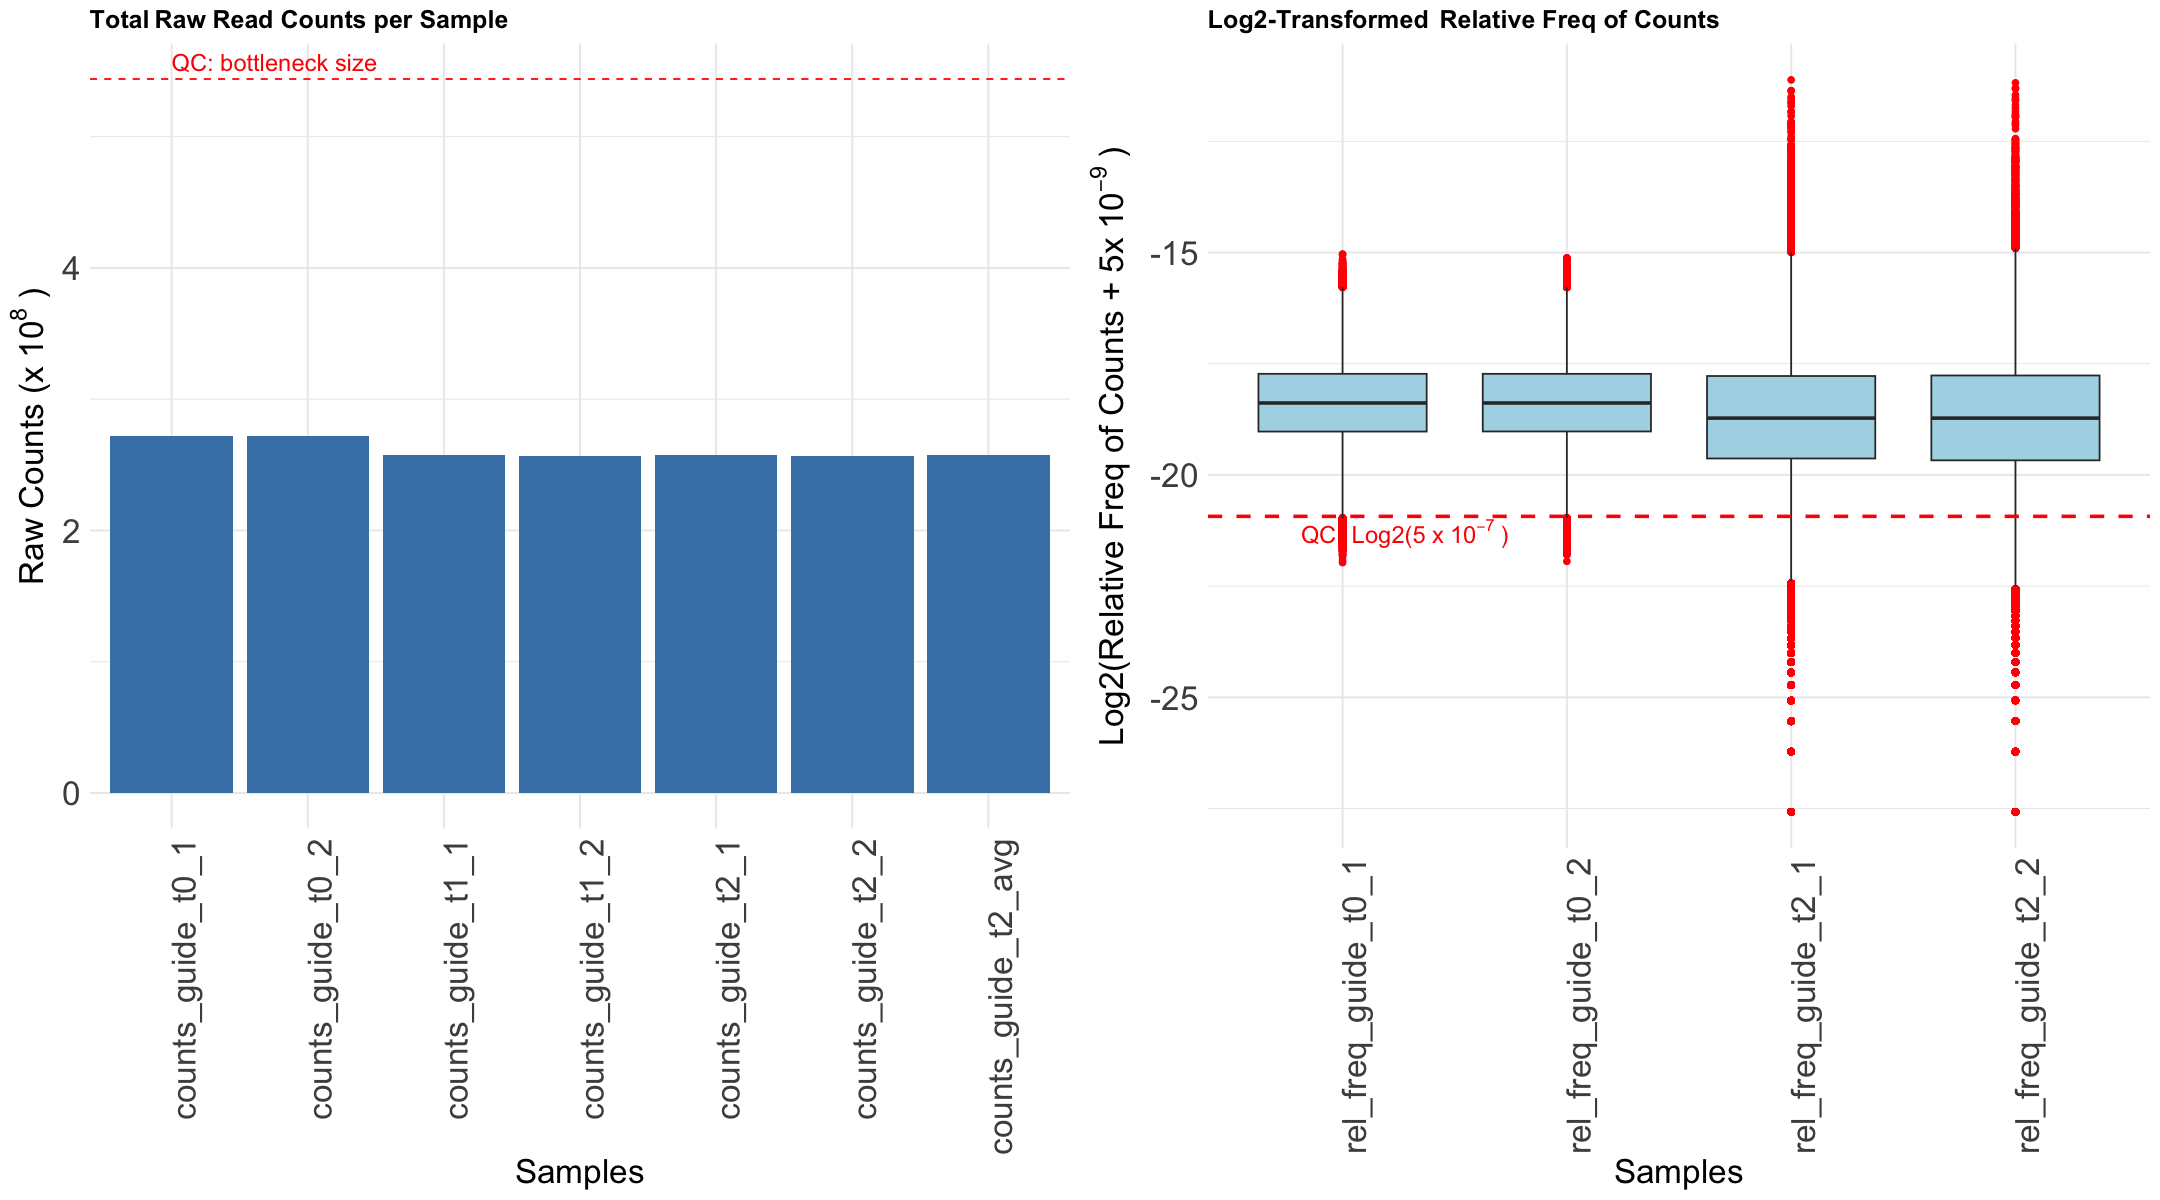

In [7]:
#raw counts QC
n_construct <- length(unique(cell_lib_guide2$guide_id))  # number of unique guides

## barplot of raw counts
sample_sum_df = cell_lib_guide2 %>% 
  dplyr::select(contains("counts_guide")) %>% 
  summarise_all(sum) %>% 
  gather() %>% 
  dplyr::rename(sample = key,
                counts_sum = value)

theme_text = theme(
        plot.title = element_markdown(size = 15, face = "bold"),   # Title size, add 'face = "bold"' if needed'
        axis.title.x = element_text(size = 20),  # X-axis title
        axis.title.y = element_text(size = 20),  # Y-axis title
        axis.text.x = element_text(size = 20),   # X-axis text
        axis.text.y = element_text(size = 20),   # Y-axis text
        legend.title = element_text(size = 20),  # Legend title
        legend.text = element_text(size = 20),   # Legend text
        strip.text = element_text(size = 30)     # Facet labels
    )

options(repr.plot.width = 10, repr.plot.height = 10)
barplot_countSum = ggplot(sample_sum_df, aes(x = sample, y = counts_sum)) +
                   geom_bar(stat = "identity", fill = "steelblue") +  # Bar plot
                   geom_hline(yintercept = bottleneck, linetype = "dashed", color = "red") +  # Reference line
                   annotate("text", x = 1, y = bottleneck, label = "QC: bottleneck size", 
                             vjust = -0.5, hjust = 0, color = "red", size = 5) +  # Annotation for the red line
                   theme_minimal() +
                   labs(x = "Samples", y = bquote("Raw Counts (x"~10^8~")"),, title = "Total Raw Read Counts per Sample") +
                   theme_text +
                   scale_y_continuous(labels = scales::label_number(scale = 1e-8)) +  # Convert y-axis to 1e8 units
                   theme(axis.text.x = element_text(angle = 90, hjust = 1))  # Rotate x-axis labels

                
## boxplot of relative frequency of the guides
pseudo_counts = 5e-9
rel_freq_df_long <- cell_lib_guide2 %>% 
  dplyr::select(contains("rel_freq_guide")) %>%
  mutate_all(~ log2(. + pseudo_counts)) %>%
  tibble::rownames_to_column(var = "Sample") %>%
  tidyr::gather(key = "Condition", value = "Log2_Value", -Sample)

# Boxplot
boxplot_countRelFreq = ggplot(rel_freq_df_long, aes(x = Condition, y = Log2_Value)) +
                              geom_boxplot(fill = "lightblue", outlier.color = "red") +
                              geom_hline(yintercept = log2(5e-7), linetype = "dashed", color = "red", linewidth = 1) +  # Reference line at log2(3e-6)
                              annotate("text", x = 1, y = log2(5e-7), label = expression(QC: "Log2(5 x"~10^-7~")"), 
                                       vjust = 1.1, hjust = 0.2, color = "red", size = 5) +  # Annotation for the red line
                              theme_minimal() +
                              labs(x = "Samples", y = bquote("Log2(Relative Freq of Counts + 5x"~10^-9~")"), title = "Log2-Transformed Relative Freq of Counts") +
                              theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                              theme_text
# Grid arrange scatter plots
options(repr.plot.width = 18, repr.plot.height = 10)
grid.arrange(arrangeGrob(barplot_countSum, ncol=1),
             arrangeGrob(boxplot_countRelFreq, ncol=1),
             ncol = 2
             #,top = "Quality Control (QC): barplot of raw counts and boxplot of relative frequency of guides counts"
             )


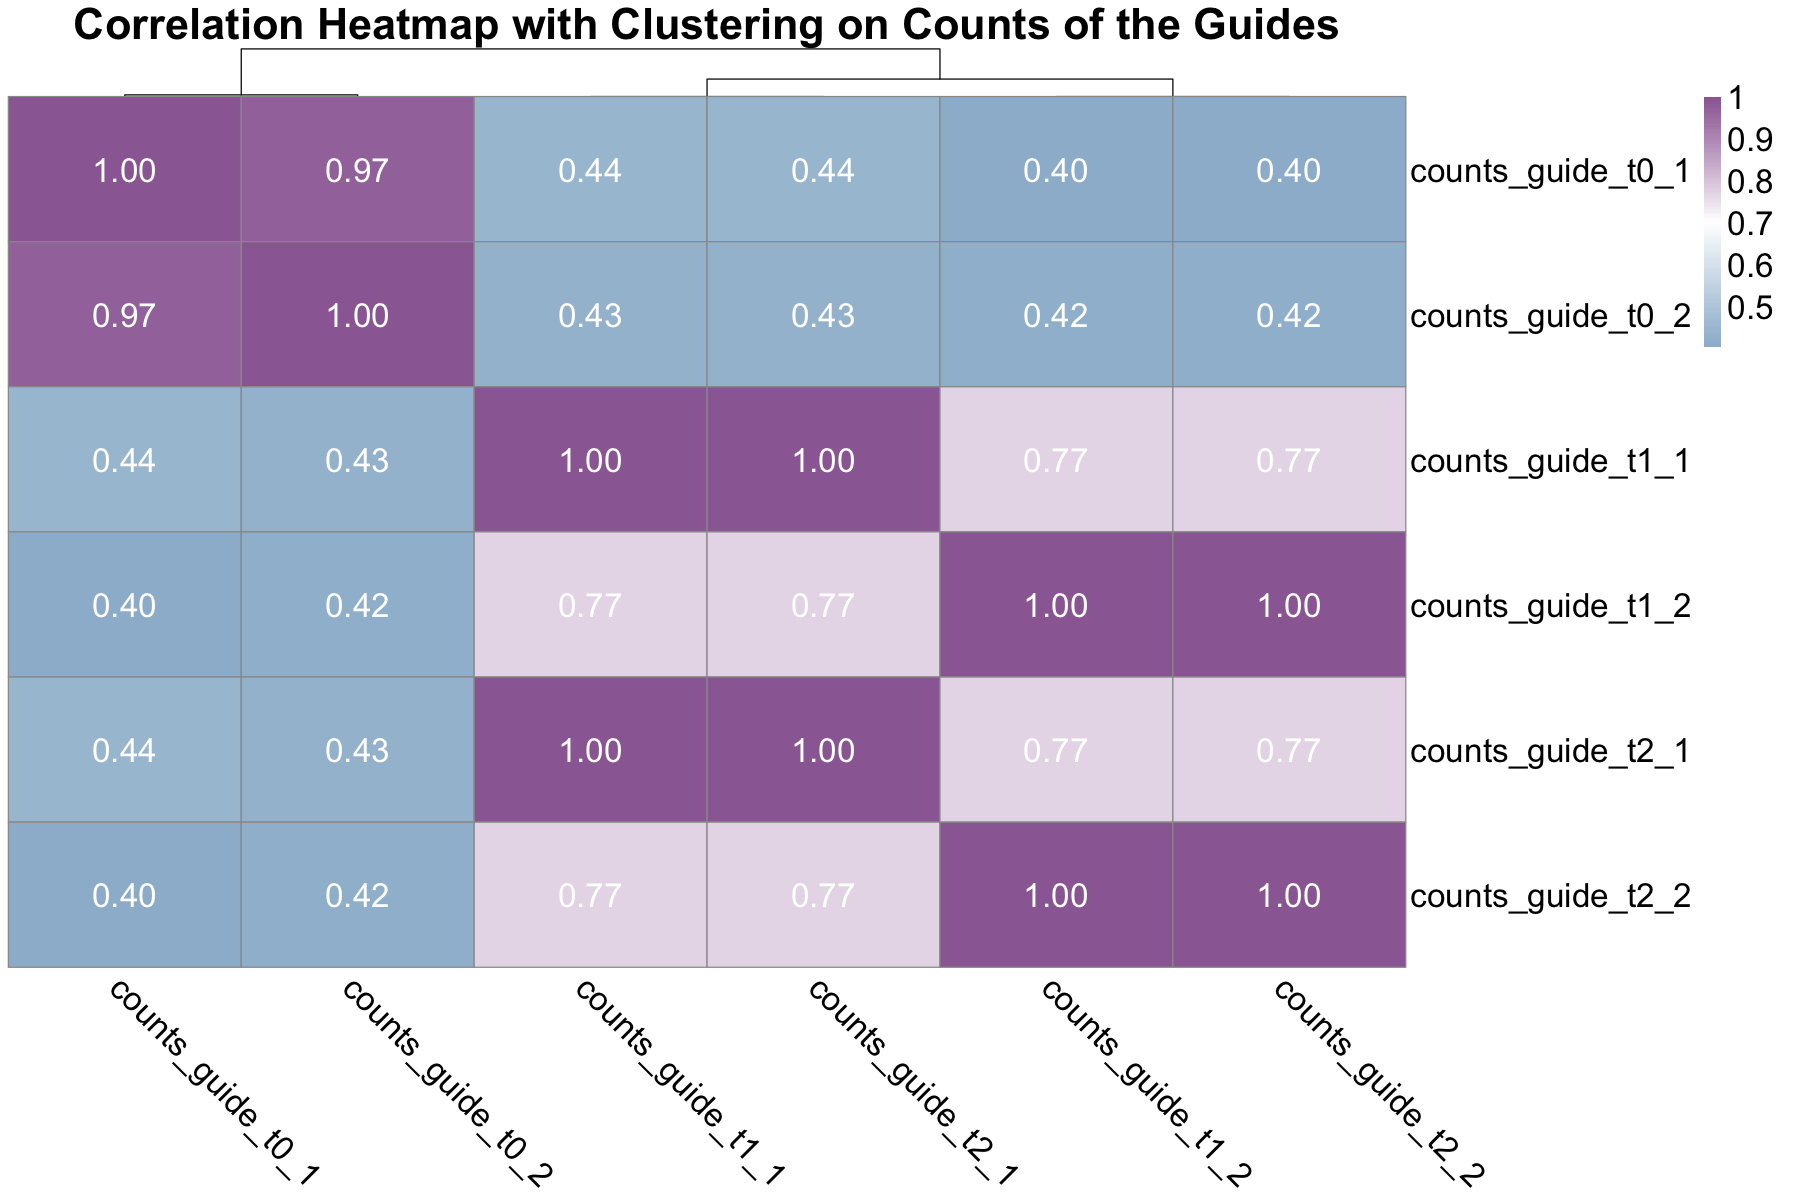

In [8]:
# Compute and visualize correlation matrix for counts of the guides
data = cell_lib_guide2 %>% dplyr::select(counts_guide_t0_1, counts_guide_t0_2,
                                         counts_guide_t1_1, counts_guide_t1_2,
                                         counts_guide_t2_1, counts_guide_t2_2)
cor_matrix <- cor(data, method = "pearson")  # Compute correlation matrix
# **Apply Hierarchical Clustering**
hc <- hclust(dist(cor_matrix))  # Cluster based on distance

# **Generate Heatmap with Clustering**
options(repr.plot.width = 15, repr.plot.height = 10)
p = pheatmap(cor_matrix,
         clustering_method = "average",  # Hierarchical clustering
         cluster_rows = F,
         cluster_cols = T,
         fontsize_number = 20,
         angle_col = 315,
         fontsize = 20,
         treeheight_col = 25,
         number_color = "white",
         display_numbers = TRUE,  # Show correlation values
         color = colorRampPalette(c("#9DBAD2", "white", "#9C6BA3"))(100),
         main = "Correlation Heatmap with Clustering on Counts of the Guides",
         silent = F)  # Hide axis labels


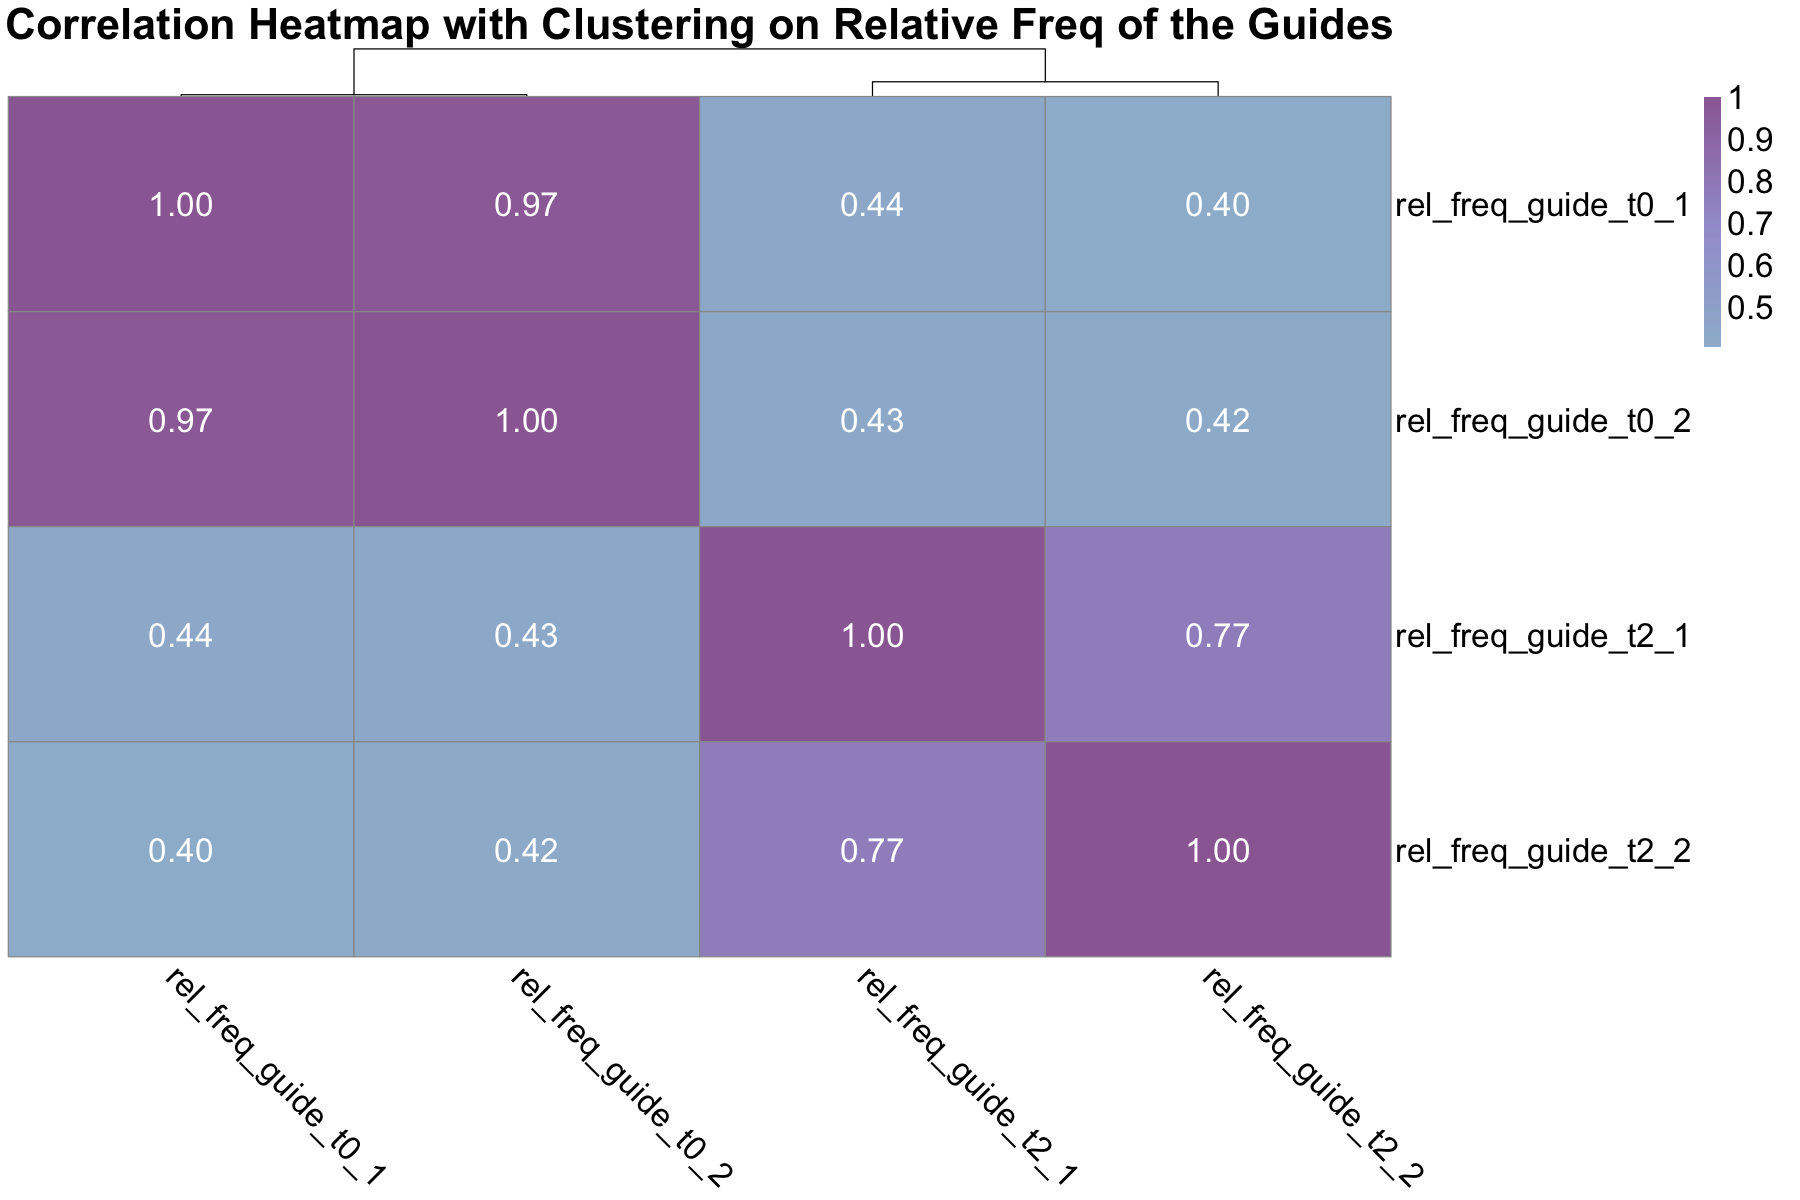

In [9]:
# Compute and visualize correlation matrix for relative frequency of the guides
data = cell_lib_guide2 %>% dplyr::select(rel_freq_guide_t0_1, rel_freq_guide_t0_2,
                                         rel_freq_guide_t2_1, rel_freq_guide_t2_2)
cor_matrix <- cor(data, method = "pearson")  # Compute correlation matrix
# **Apply Hierarchical Clustering**
hc <- hclust(dist(cor_matrix))  # Cluster based on distance

# **Generate Heatmap with Clustering**
options(repr.plot.width = 15, repr.plot.height = 10)
p = pheatmap(cor_matrix,
         clustering_method = "average",  # Hierarchical clustering
         cluster_rows = F,
         cluster_cols = T,
         fontsize_number = 20,
         angle_col = 315,
         fontsize = 20,
         treeheight_col = 25,
         number_color = "white",
         display_numbers = TRUE,  # Show correlation values
         color = colorRampPalette(c("#9DBAD2", "#a39dd2", "#9C6BA3"))(100),
         main = "Correlation Heatmap with Clustering on Relative Freq of the Guides",
         silent = F)  # Hide axis labels


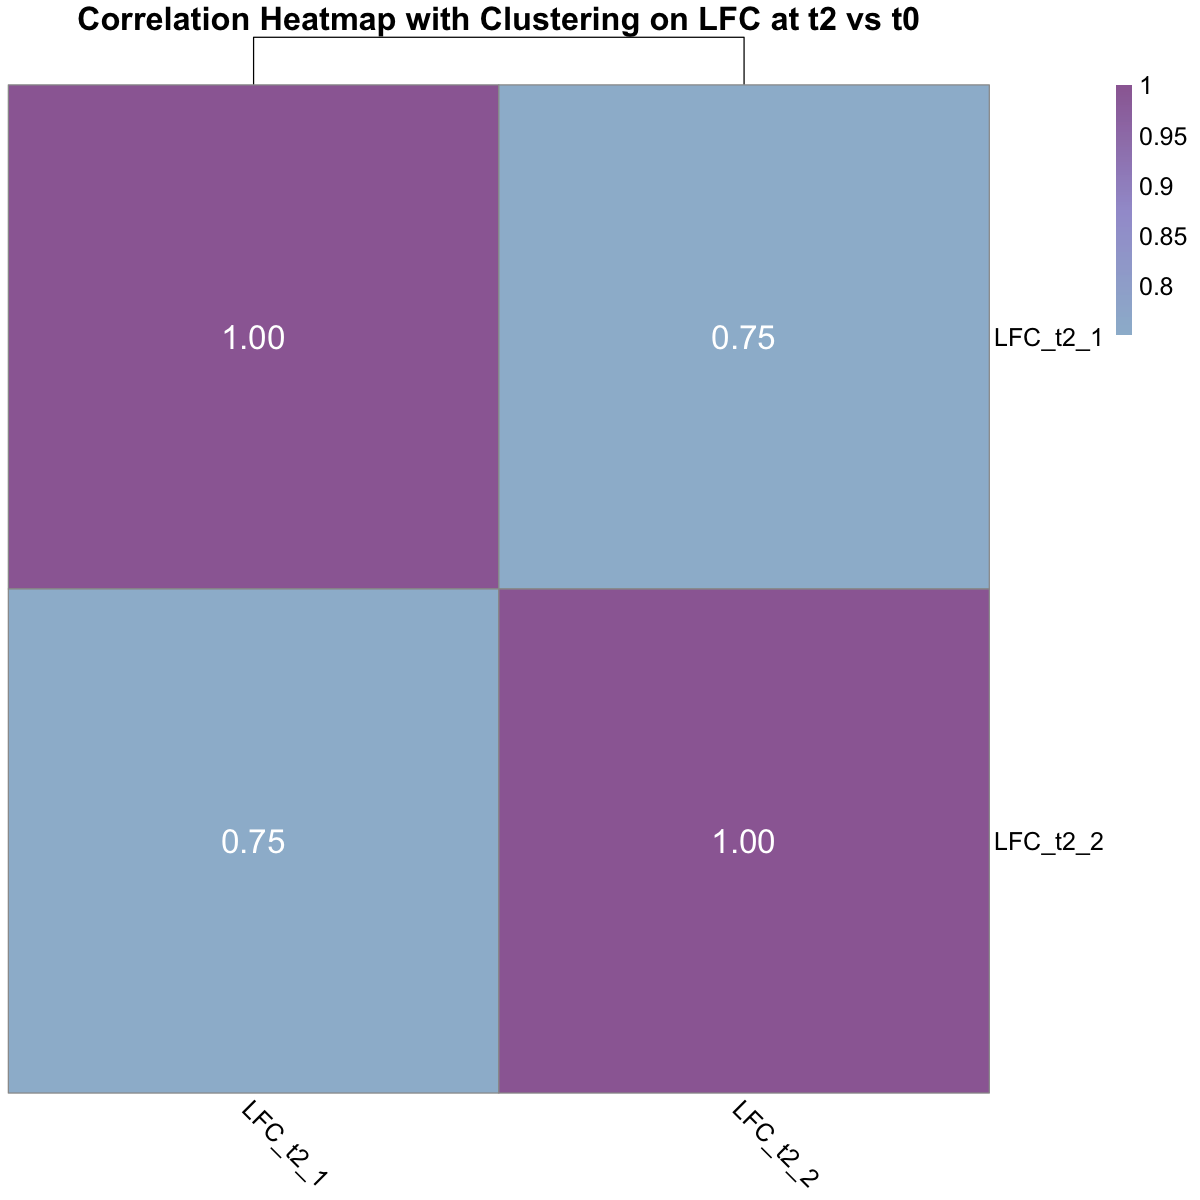

In [10]:
# Compute and visualize correlation matrix on LFC at t2 vs t0
data = cell_lib_guide2 %>% dplyr::select(LFC_t2_1, LFC_t2_2)
cor_matrix <- cor(data, method = "pearson")  # Compute correlation matrix
# **Apply Hierarchical Clustering**
hc <- hclust(dist(cor_matrix))  # Cluster based on distance

# **Generate Heatmap with Clustering**
options(repr.plot.width = 10, repr.plot.height = 10)
pheatmap(cor_matrix,
         clustering_method = "average",  # Hierarchical clustering
         cluster_rows = F,
         cluster_cols = TRUE,
         fontsize_number = 20,
         angle_col = 315,
         fontsize = 15,
         treeheight_col = 25,
         number_color = "white",
         display_numbers = TRUE,  # Show correlation values
         color = colorRampPalette(c("#9DBAD2", "#a39dd2", "#9C6BA3"))(100),
         main = "Correlation Heatmap with Clustering on LFC at t2 vs t0",
         silent = F)  # Hide axis labels


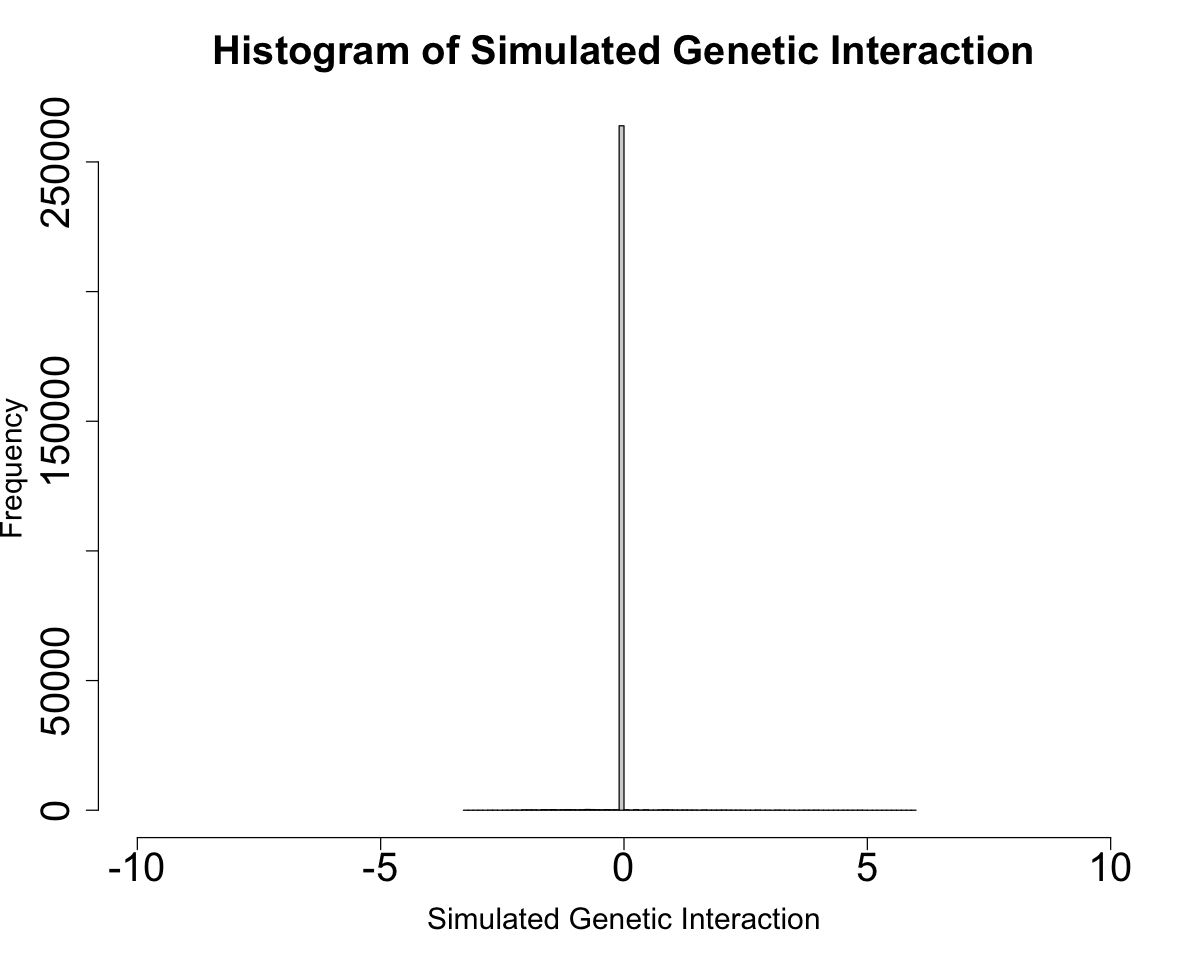

In [12]:
# histogram and plot of Genetic Interaction
options(repr.plot.width = 10, repr.plot.height = 8)   
par(bg = "white")  # Set background of entire plot region to white 
hist(cell_lib_guide2$interaction_gene, breaks = 100, main = "Histogram of Simulated Genetic Interaction", xlab = "Simulated Genetic Interaction", ylab = "Frequency", 
     xlim = c(-10, 10),
     cex.axis = 2,
     cex.lab = 1.5,
     cex.main = 2)

## PART 2: Data Visualization

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_bar()`)."


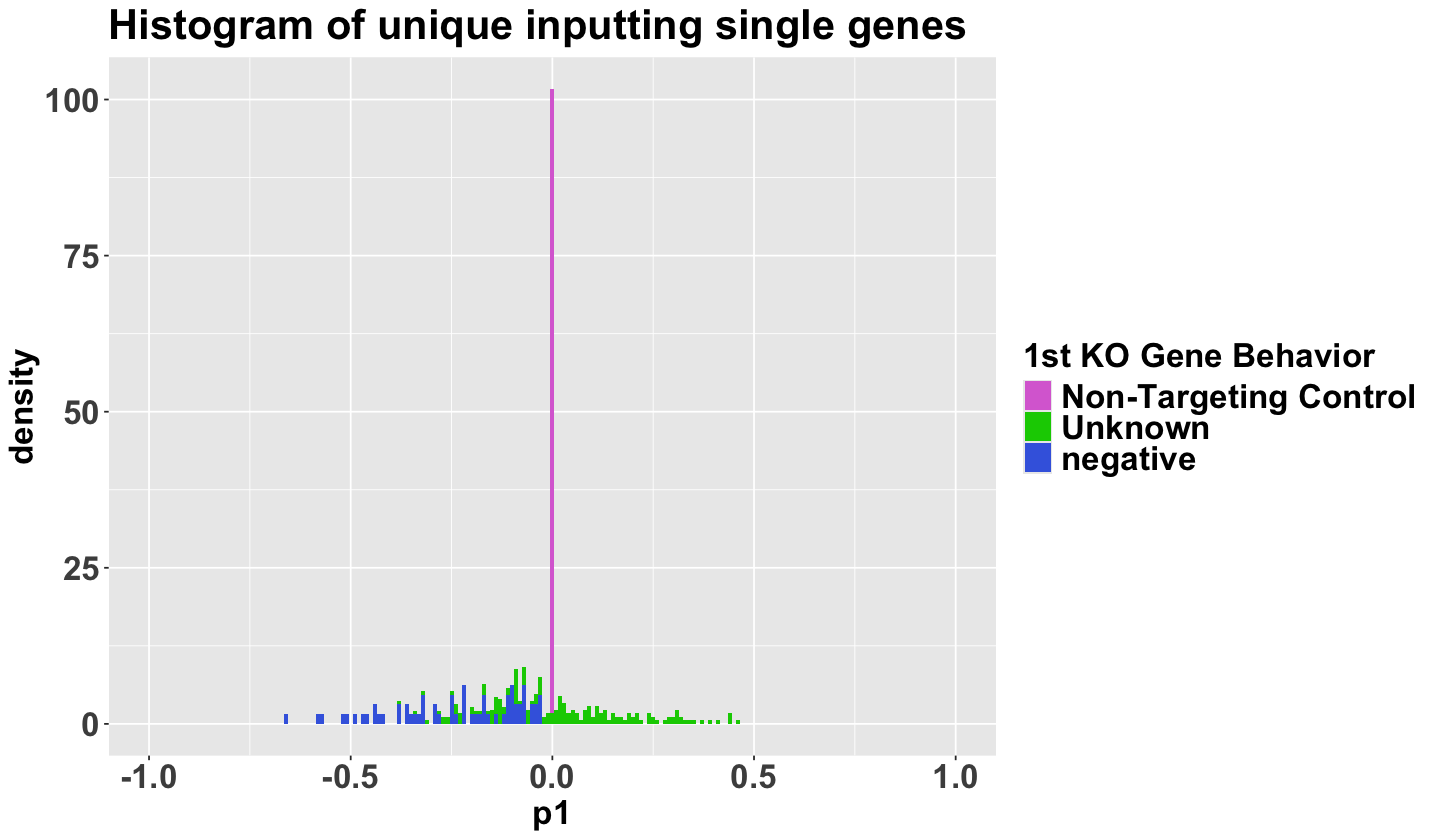

In [16]:
############ Distribution of Theoretical Phenotypes of Inputting Genes ###########################################################
# histograms for theoretical phenotypes of inputting genes - SKO
group_colors = c("Unknown"="green3", "negative"="royalblue", "positive"="brown1", "Non-Targeting Control"="orchid")
theme_text = theme(
        plot.title = element_text(size = 25, face = "bold"),   # Title size, add 'face = "bold"' if needed'
        axis.title.x = element_text(size = 20, face = "bold"),  # X-axis title
        axis.title.y = element_text(size = 20, face = "bold"),  # Y-axis title
        axis.text.x = element_text(size = 20, face = "bold"),   # X-axis text
        axis.text.y = element_text(size = 20, face = "bold"),   # Y-axis text
        legend.title = element_text(size = 20, face = "bold"),  # Legend title
        legend.text = element_text(size = 20, face = "bold"),   # Legend text
        strip.text = element_text(size = 30, face = "bold")     # Facet labels
    )
    
hist0 = ggplot(data = cell_lib_guide2 %>% filter(KO_type=="SKO"), aes(x=p1, fill=gene1_behavior)) +
  stat_bin(aes(y= ..density..), bins = n, binwidth = 0.01) +
  xlim(-1,1) +
  scale_fill_manual(values = group_colors, name = "1st KO Gene Behavior") +
  scale_color_manual(values = group_colors) +
  ggtitle("Histogram of unique inputting single genes") +
  theme_text

options(repr.plot.width = 12, repr.plot.height = 7)
hist0
#ggsave("figures/v3_run4_hist0.jpeg", plot = hist0, width = 10, height = 6, dpi = 300)

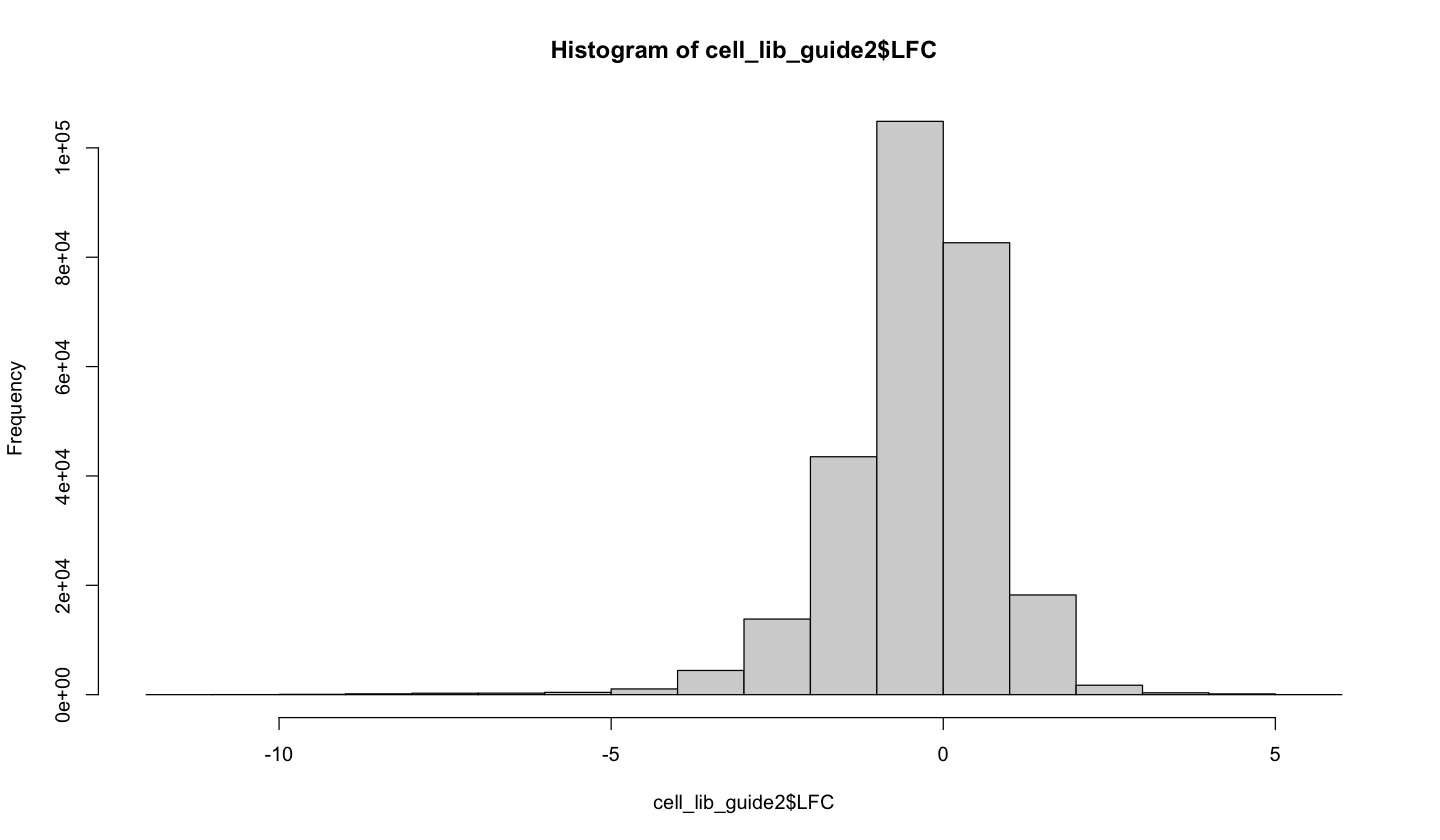

In [17]:
# overall LFC distribution
hist(cell_lib_guide2$LFC)

Warning message:
"Removed 13 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`)."


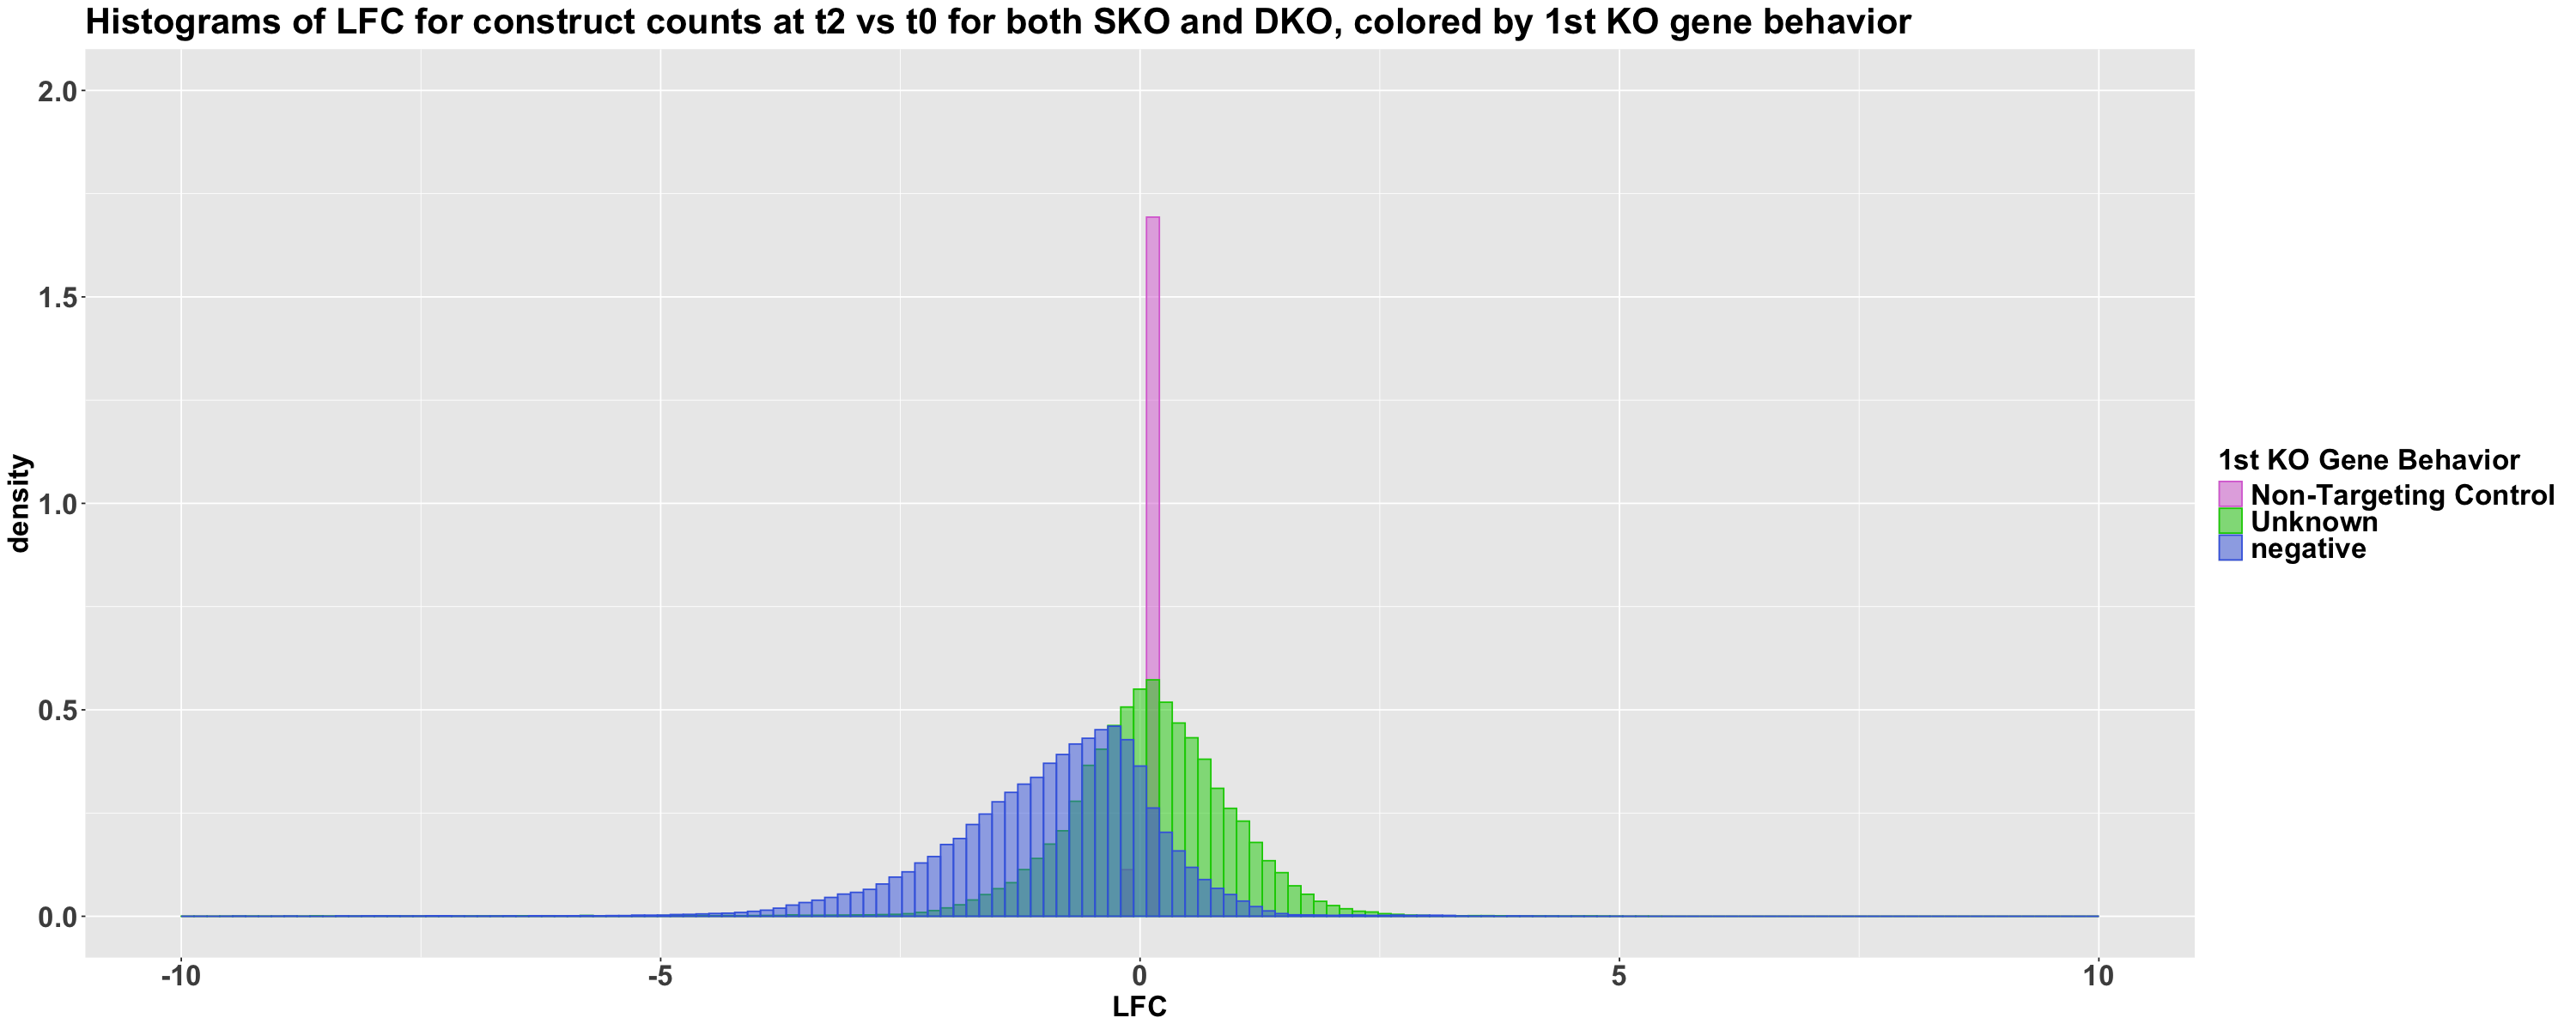

In [18]:
# overall LFC distributions
xrange = c(-10,10)
yrange = c(0,2)
## adjust gene class colors accordingly
group_colors = c("Unknown"="green3", "negative"="royalblue", "positive"="brown1", "Non-Targeting Control"="orchid")
# modify text size
theme_text = theme(
        plot.title = element_text(size = 25, face = "bold"),   # Title size, add 'face = "bold"' if needed'
        axis.title.x = element_text(size = 20, face = "bold"),  # X-axis title
        axis.title.y = element_text(size = 20, face = "bold"),  # Y-axis title
        axis.text.x = element_text(size = 20, face = "bold"),   # X-axis text
        axis.text.y = element_text(size = 20, face = "bold"),   # Y-axis text
        legend.title = element_text(size = 20, face = "bold"),  # Legend title
        legend.text = element_text(size = 20, face = "bold"),   # Legend text
        strip.text = element_text(size = 30, face = "bold")     # Facet labels
    )

options(repr.plot.width = 30, repr.plot.height = 10)
plot1 = ggplot(cell_lib_guide2, aes(x=LFC, fill = gene1_behavior, color = gene1_behavior)) +
        geom_histogram(aes(y=..density..), alpha = 0.5, bins = 150, position = "identity") +
        scale_x_continuous(limits = xrange) +
        scale_y_continuous(limits = yrange) +
        scale_fill_manual(values = group_colors, name = "1st KO Gene Behavior") +
        scale_color_manual(values = group_colors, name = "1st KO Gene Behavior") +
        ggtitle("Histograms of LFC for construct counts at t2 vs t0 for both SKO and DKO, colored by 1st KO gene behavior") +
        theme_text
options(repr.plot.width = 25, repr.plot.height = 10)
plot1

Warning message:
"Removed 13 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 16 rows containing missing values or values outside the scale range
(`geom_bar()`)."
Warning message:
"A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
i Please use the `legend.position.inside` argument of `theme()` instead."
Warning message:
"Removed 13 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_bar()`)."


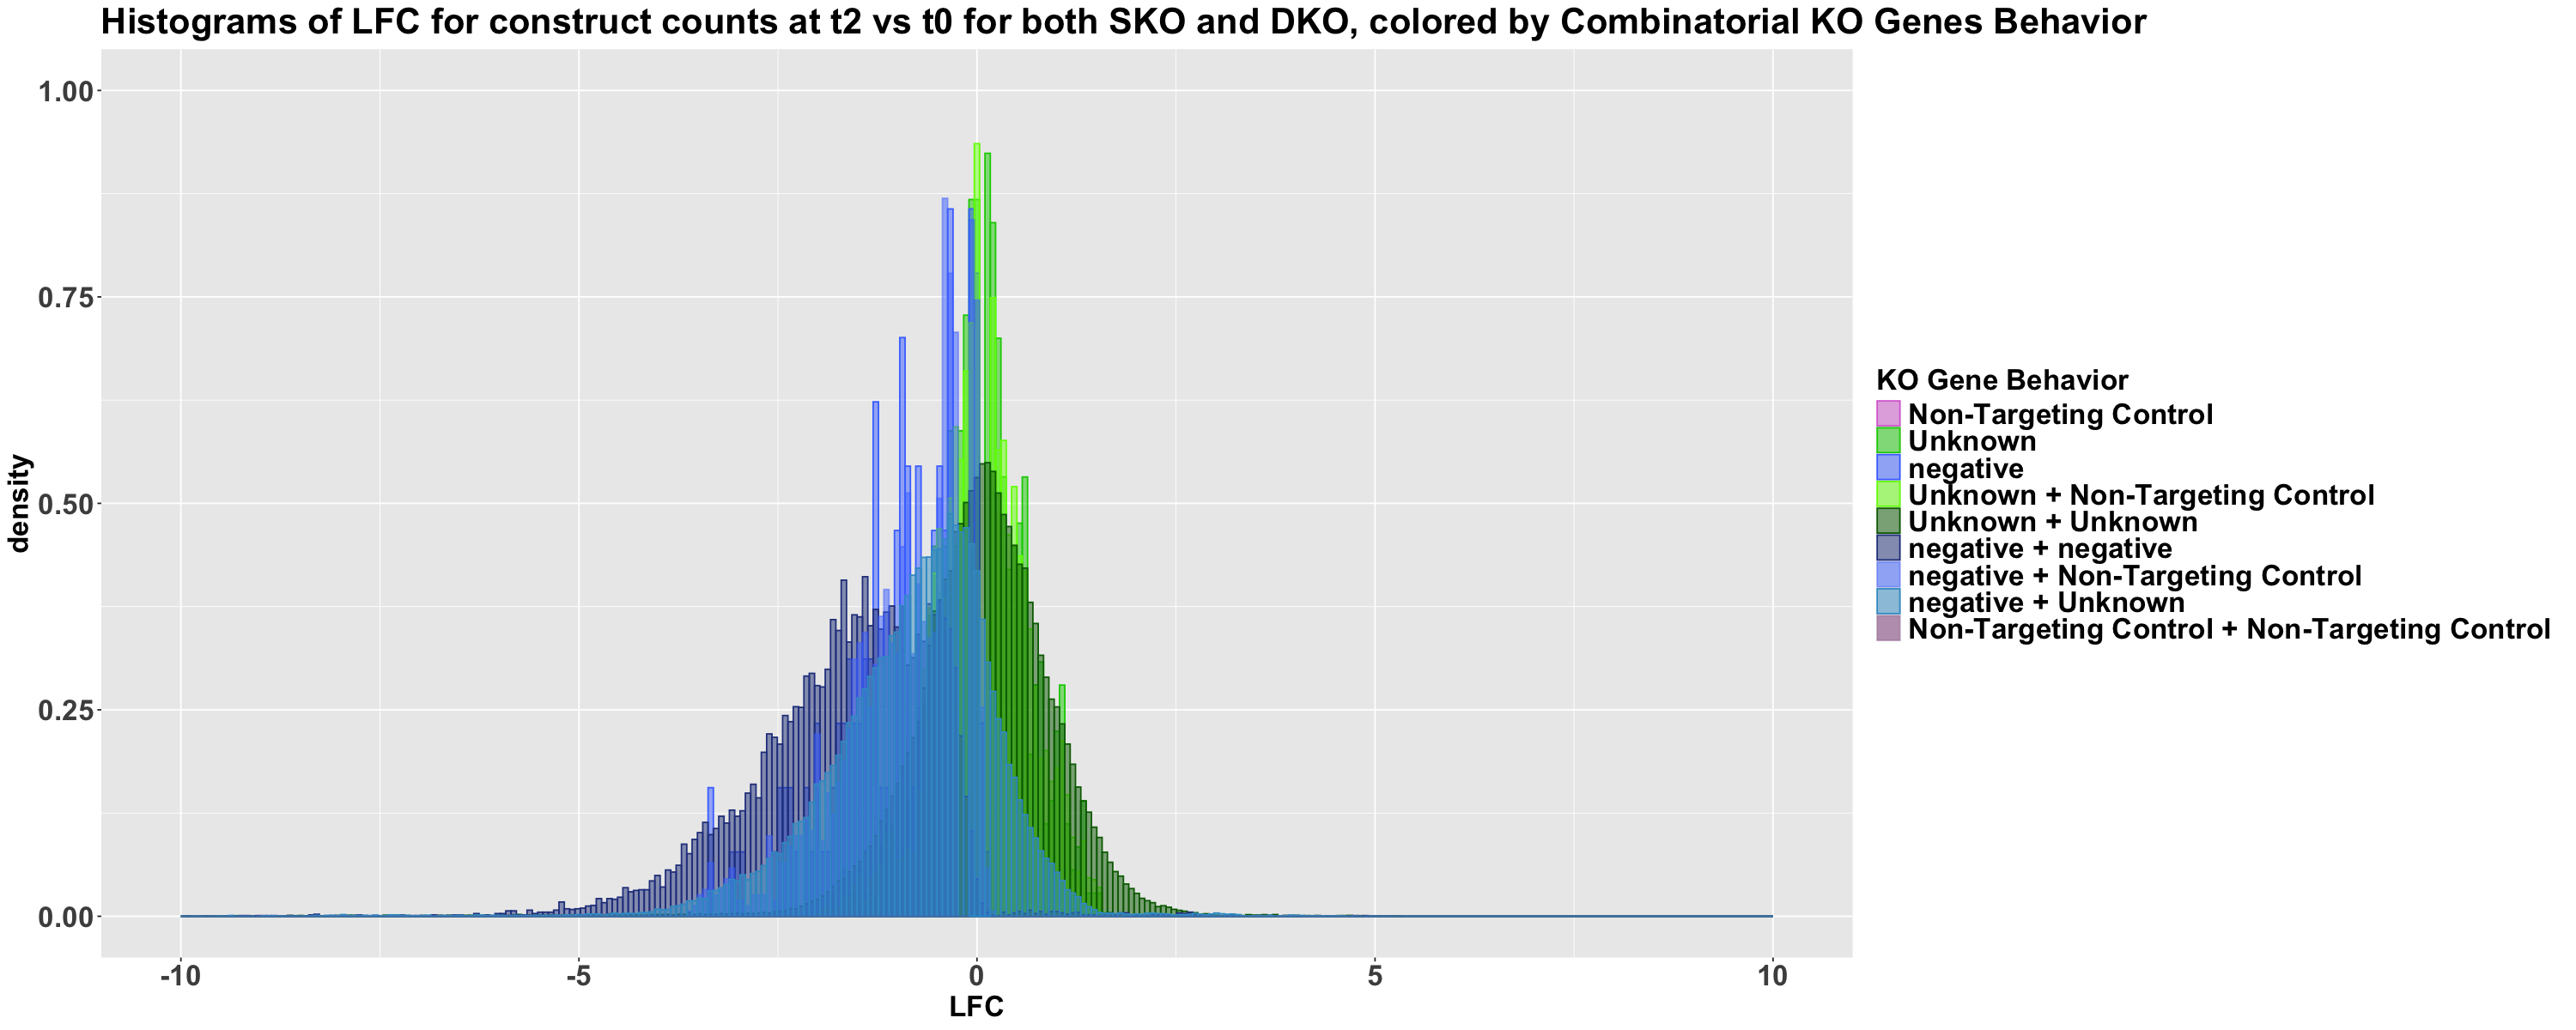

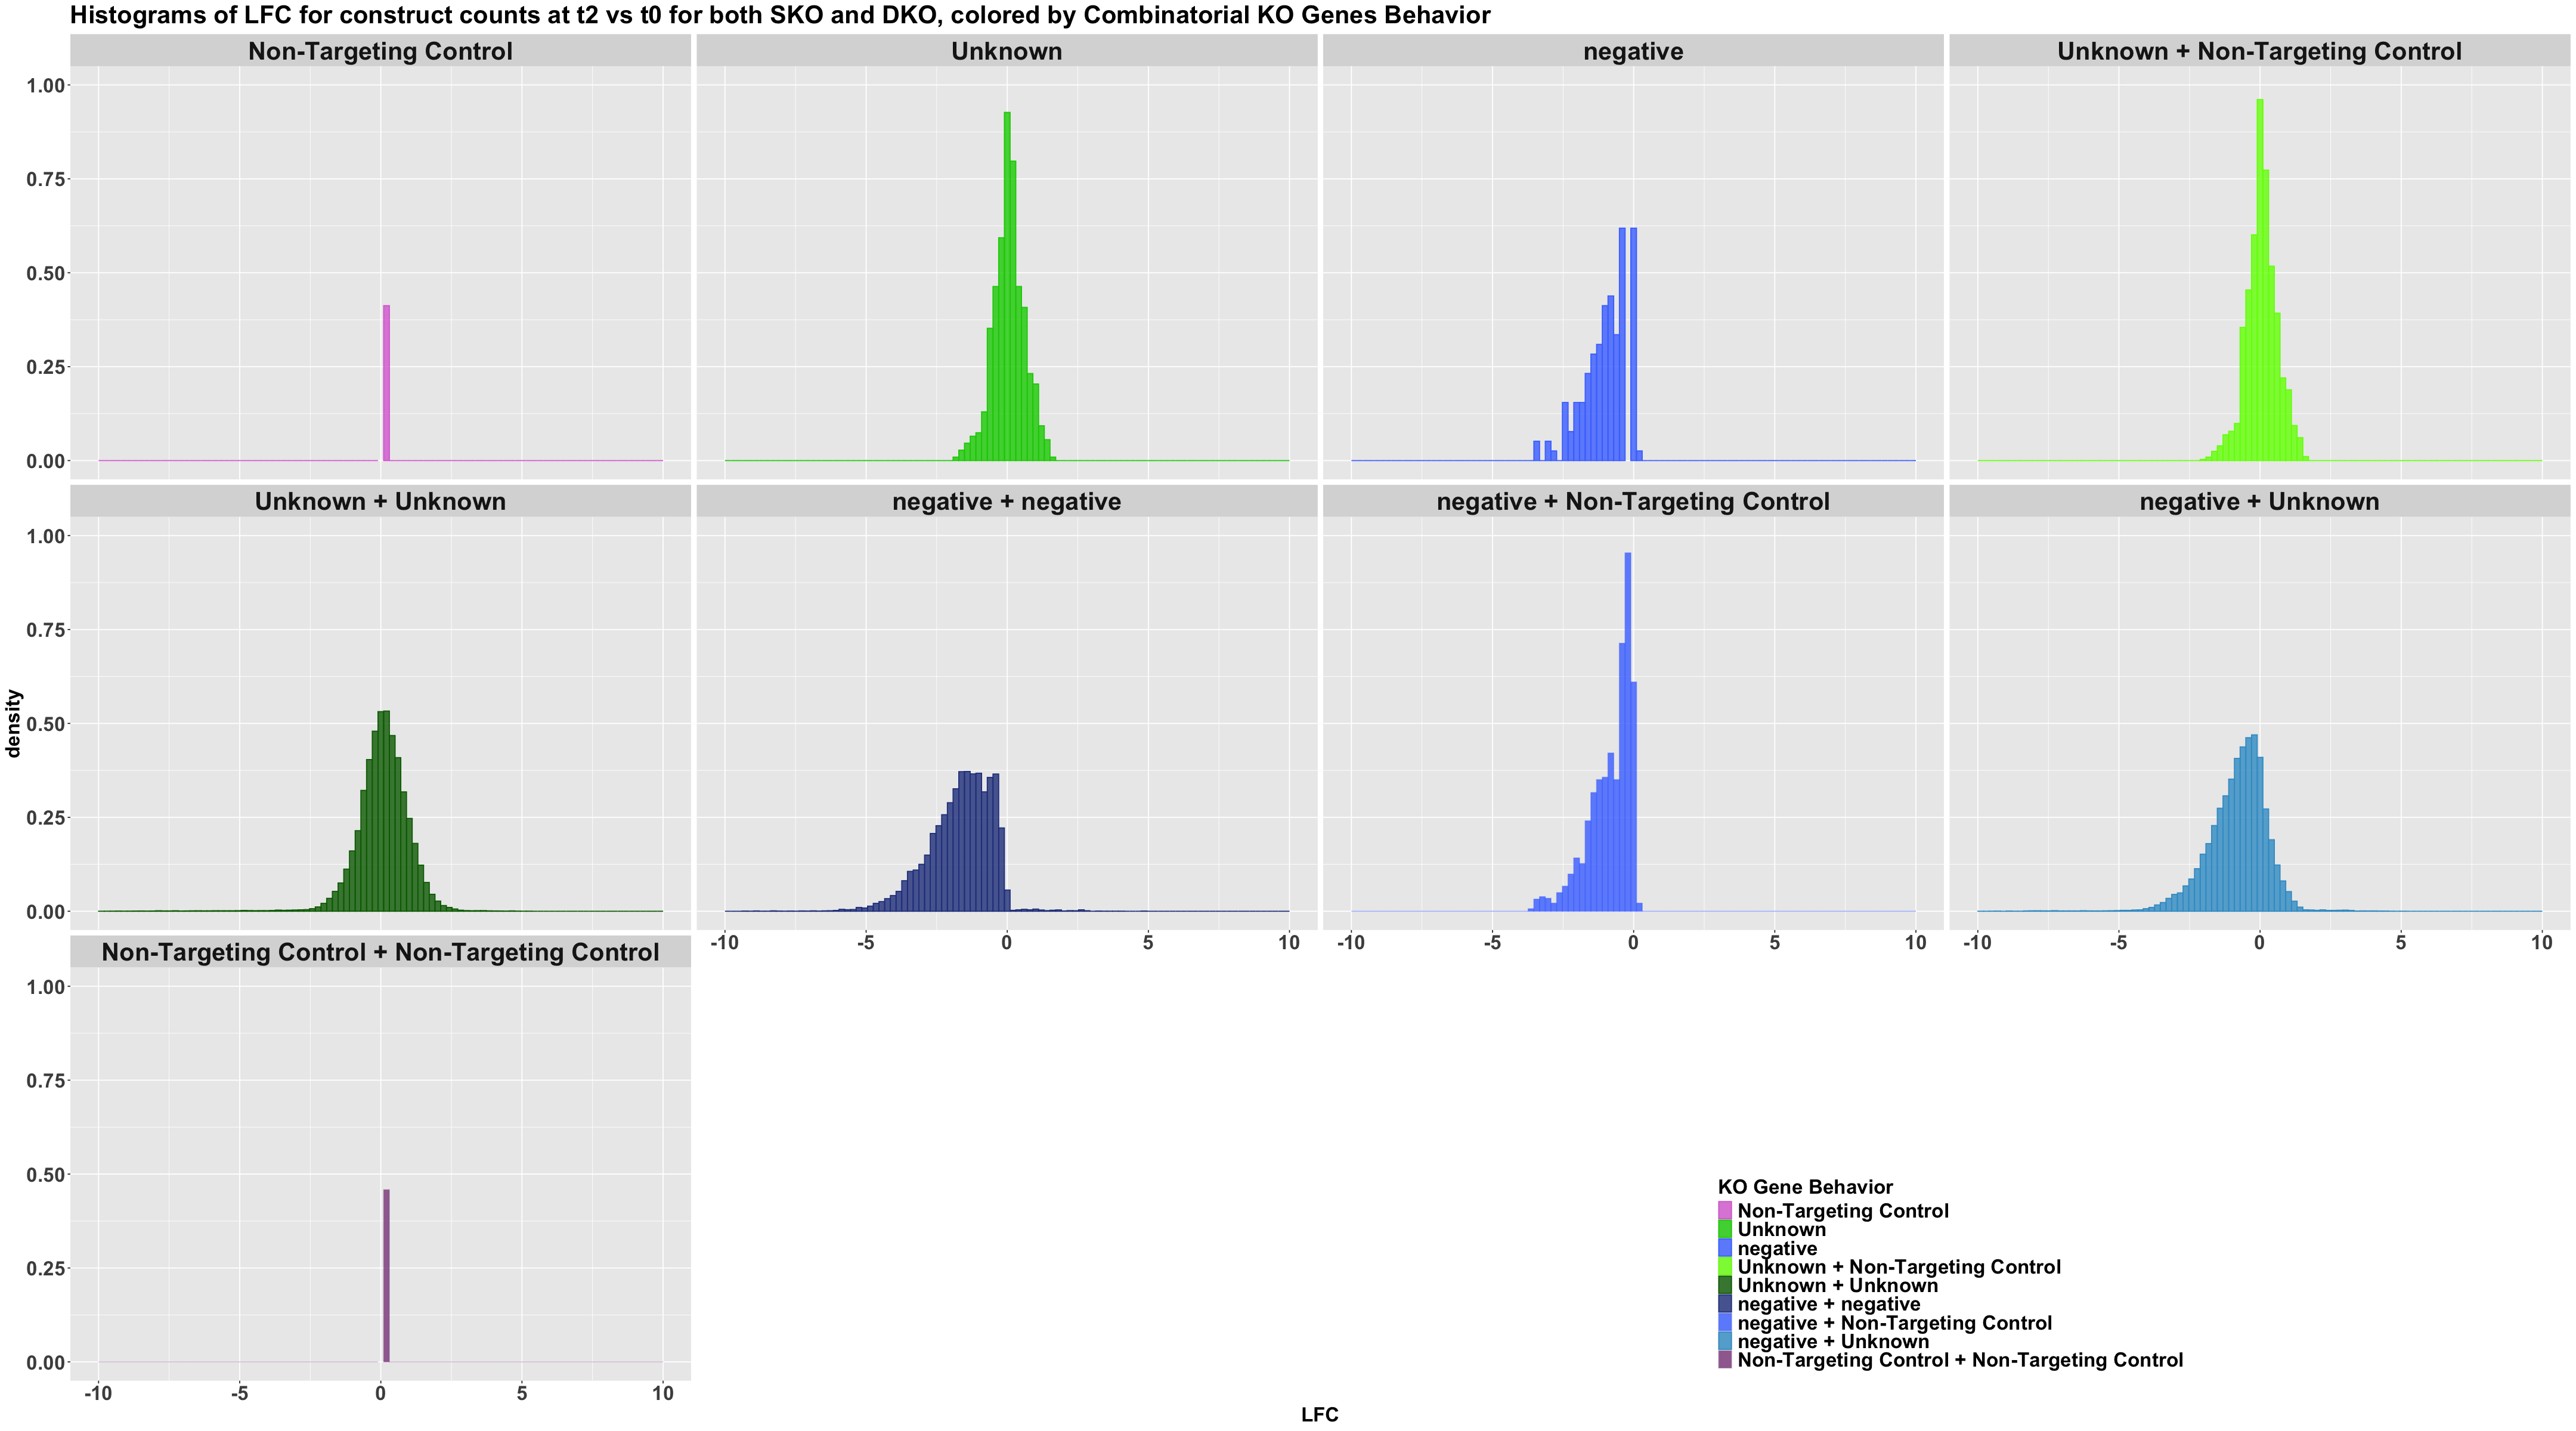

In [19]:
xrange = c(-10,10)
yrange = c(0,1)

# visualize LFC distributions by all unique combinatorial gene types
group_color2 = c("Unknown"="green3", "negative"="royalblue1", "positive"="brown1", "Non-Targeting Control"="orchid",
                 "Unknown + Non-Targeting Control"="#6fff00", "Unknown + Unknown"="#016901", 
                 "negative + Non-Targeting Control"="#4876ff77", "negative + Unknown"="#3a9ccd", "negative + positive"="#3f1a7b86", "negative + negative"="royalblue4", 
                 "positive + Non-Targeting Control"="#ee3b3b66", "positive + Unknown"="#cd8630", "positive + positive"="brown4", 
                 "Non-Targeting Control + Non-Targeting Control"="#8b47894c")
# Define order of combinatorial gene types
cell_lib_guide2$construct_type <- factor(cell_lib_guide2$construct_type,
                                         levels = c("Non-Targeting Control",                         "Unknown",                              "negative",     "positive", 
                                                    "Unknown + Non-Targeting Control",                    "Unknown + Unknown",                         "negative + negative", "positive + positive",
                                                    "negative + Non-Targeting Control",              "negative + Unknown",                   "negative + positive",
                                                    "Non-Targeting Control + Non-Targeting Control", "positive + Non-Targeting Control","positive + Unknown"))
# modify text size
theme_text = theme(
        plot.title = element_text(size = 25, face = "bold"),   # Title size, add 'face = "bold"' if needed'
        axis.title.x = element_text(size = 20, face = "bold"),  # X-axis title
        axis.title.y = element_text(size = 20, face = "bold"),  # Y-axis title
        axis.text.x = element_text(size = 20, face = "bold"),   # X-axis text
        axis.text.y = element_text(size = 20, face = "bold"),   # Y-axis text
        legend.title = element_text(size = 20, face = "bold"),  # Legend title
        legend.text = element_text(size = 20, face = "bold"),   # Legend text
        strip.text = element_text(size = 25, face = "bold")     # Facet labels
    )

# visualize by different color
options(repr.plot.width = 25, repr.plot.height = 10)
plot2 = ggplot(cell_lib_guide2, aes(x=LFC, fill = construct_type, color = construct_type)) +
        geom_histogram(aes(y=..density..), alpha = 0.5, bins = 300, position = "identity") +
        scale_x_continuous(limits = xrange) +
        scale_y_continuous(limits = yrange) +
        scale_fill_manual(values = group_color2, name = "KO Gene Behavior") +
        scale_color_manual(values = group_color2, name = "KO Gene Behavior") +
        ggtitle("Histograms of LFC for construct counts at t2 vs t0 for both SKO and DKO, colored by Combinatorial KO Genes Behavior") +
        theme_text
plot2
# visualize by deconvoluting into different box
options(repr.plot.width = 36, repr.plot.height = 20)
plot3 = ggplot(cell_lib_guide2, aes(x=LFC, fill = construct_type, color = construct_type)) +
        geom_histogram(aes(y=..density..), alpha = 0.8, bins = 100, position = "identity") +
        scale_x_continuous(limits = xrange) +
        scale_y_continuous(limits = yrange) +
        scale_fill_manual(values = group_color2, name = "KO Gene Behavior") +
        scale_color_manual(values = group_color2, name = "KO Gene Behavior") +
        facet_wrap(~construct_type, ncol = 4) +
        ggtitle("Histograms of LFC for construct counts at t2 vs t0 for both SKO and DKO, colored by Combinatorial KO Genes Behavior") +
        theme(
        legend.position = c(0.85, 0.005),   # Moves legend to bottom-right inside plot
        legend.justification = c(1, 0),    # Aligns legend to bottom-right
        legend.background = element_rect(fill = scales::alpha("white", 0.7)), # Adds transparency to legend background
        legend.key.size = unit(0.5, "cm")) +  # Adjusts legend size for better fit
        theme_text
plot3

Warning message:
"Removed 13 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_bar()`)."


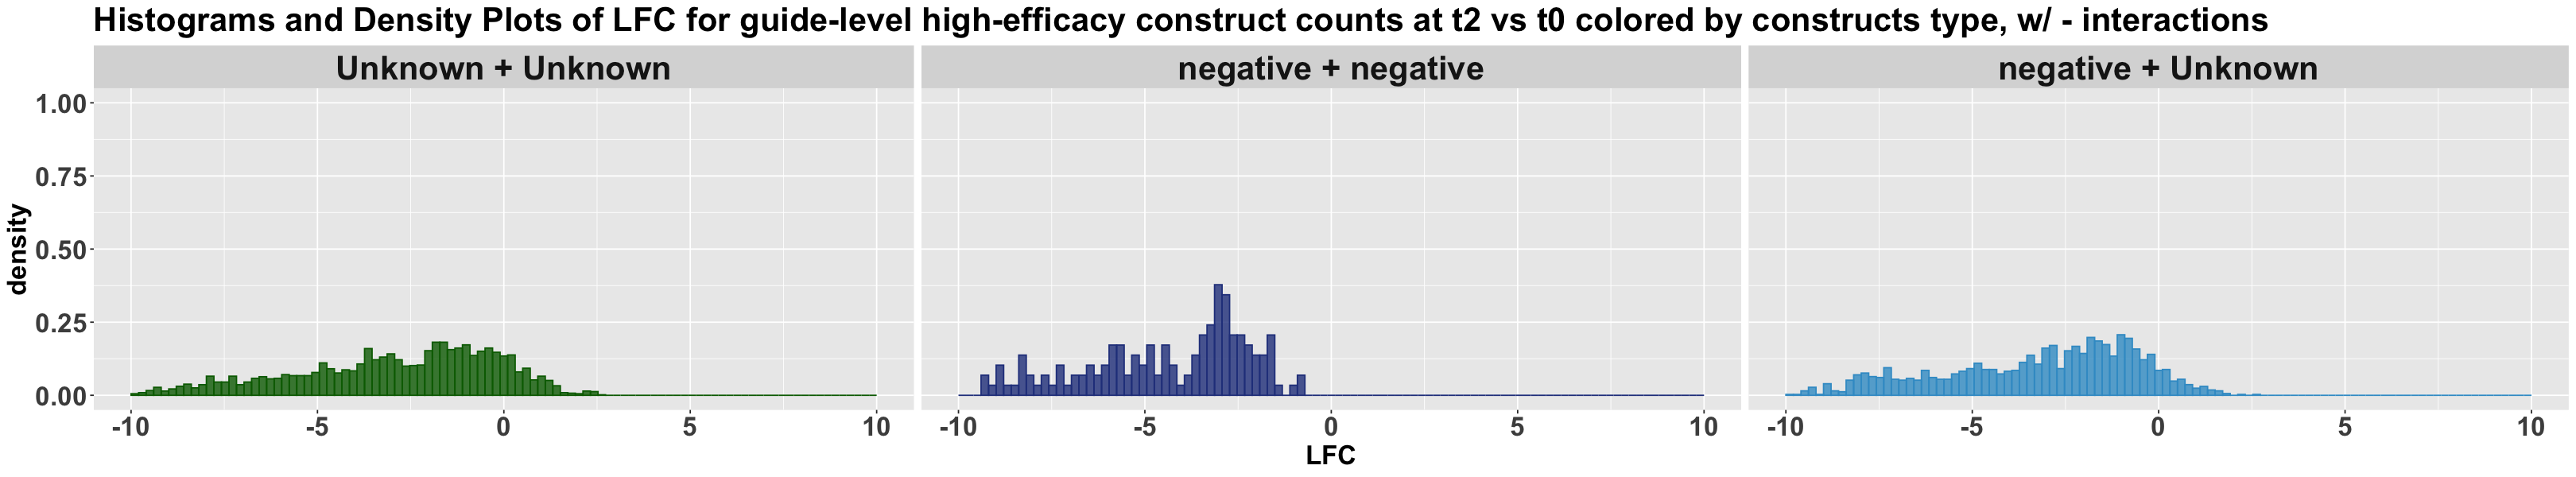

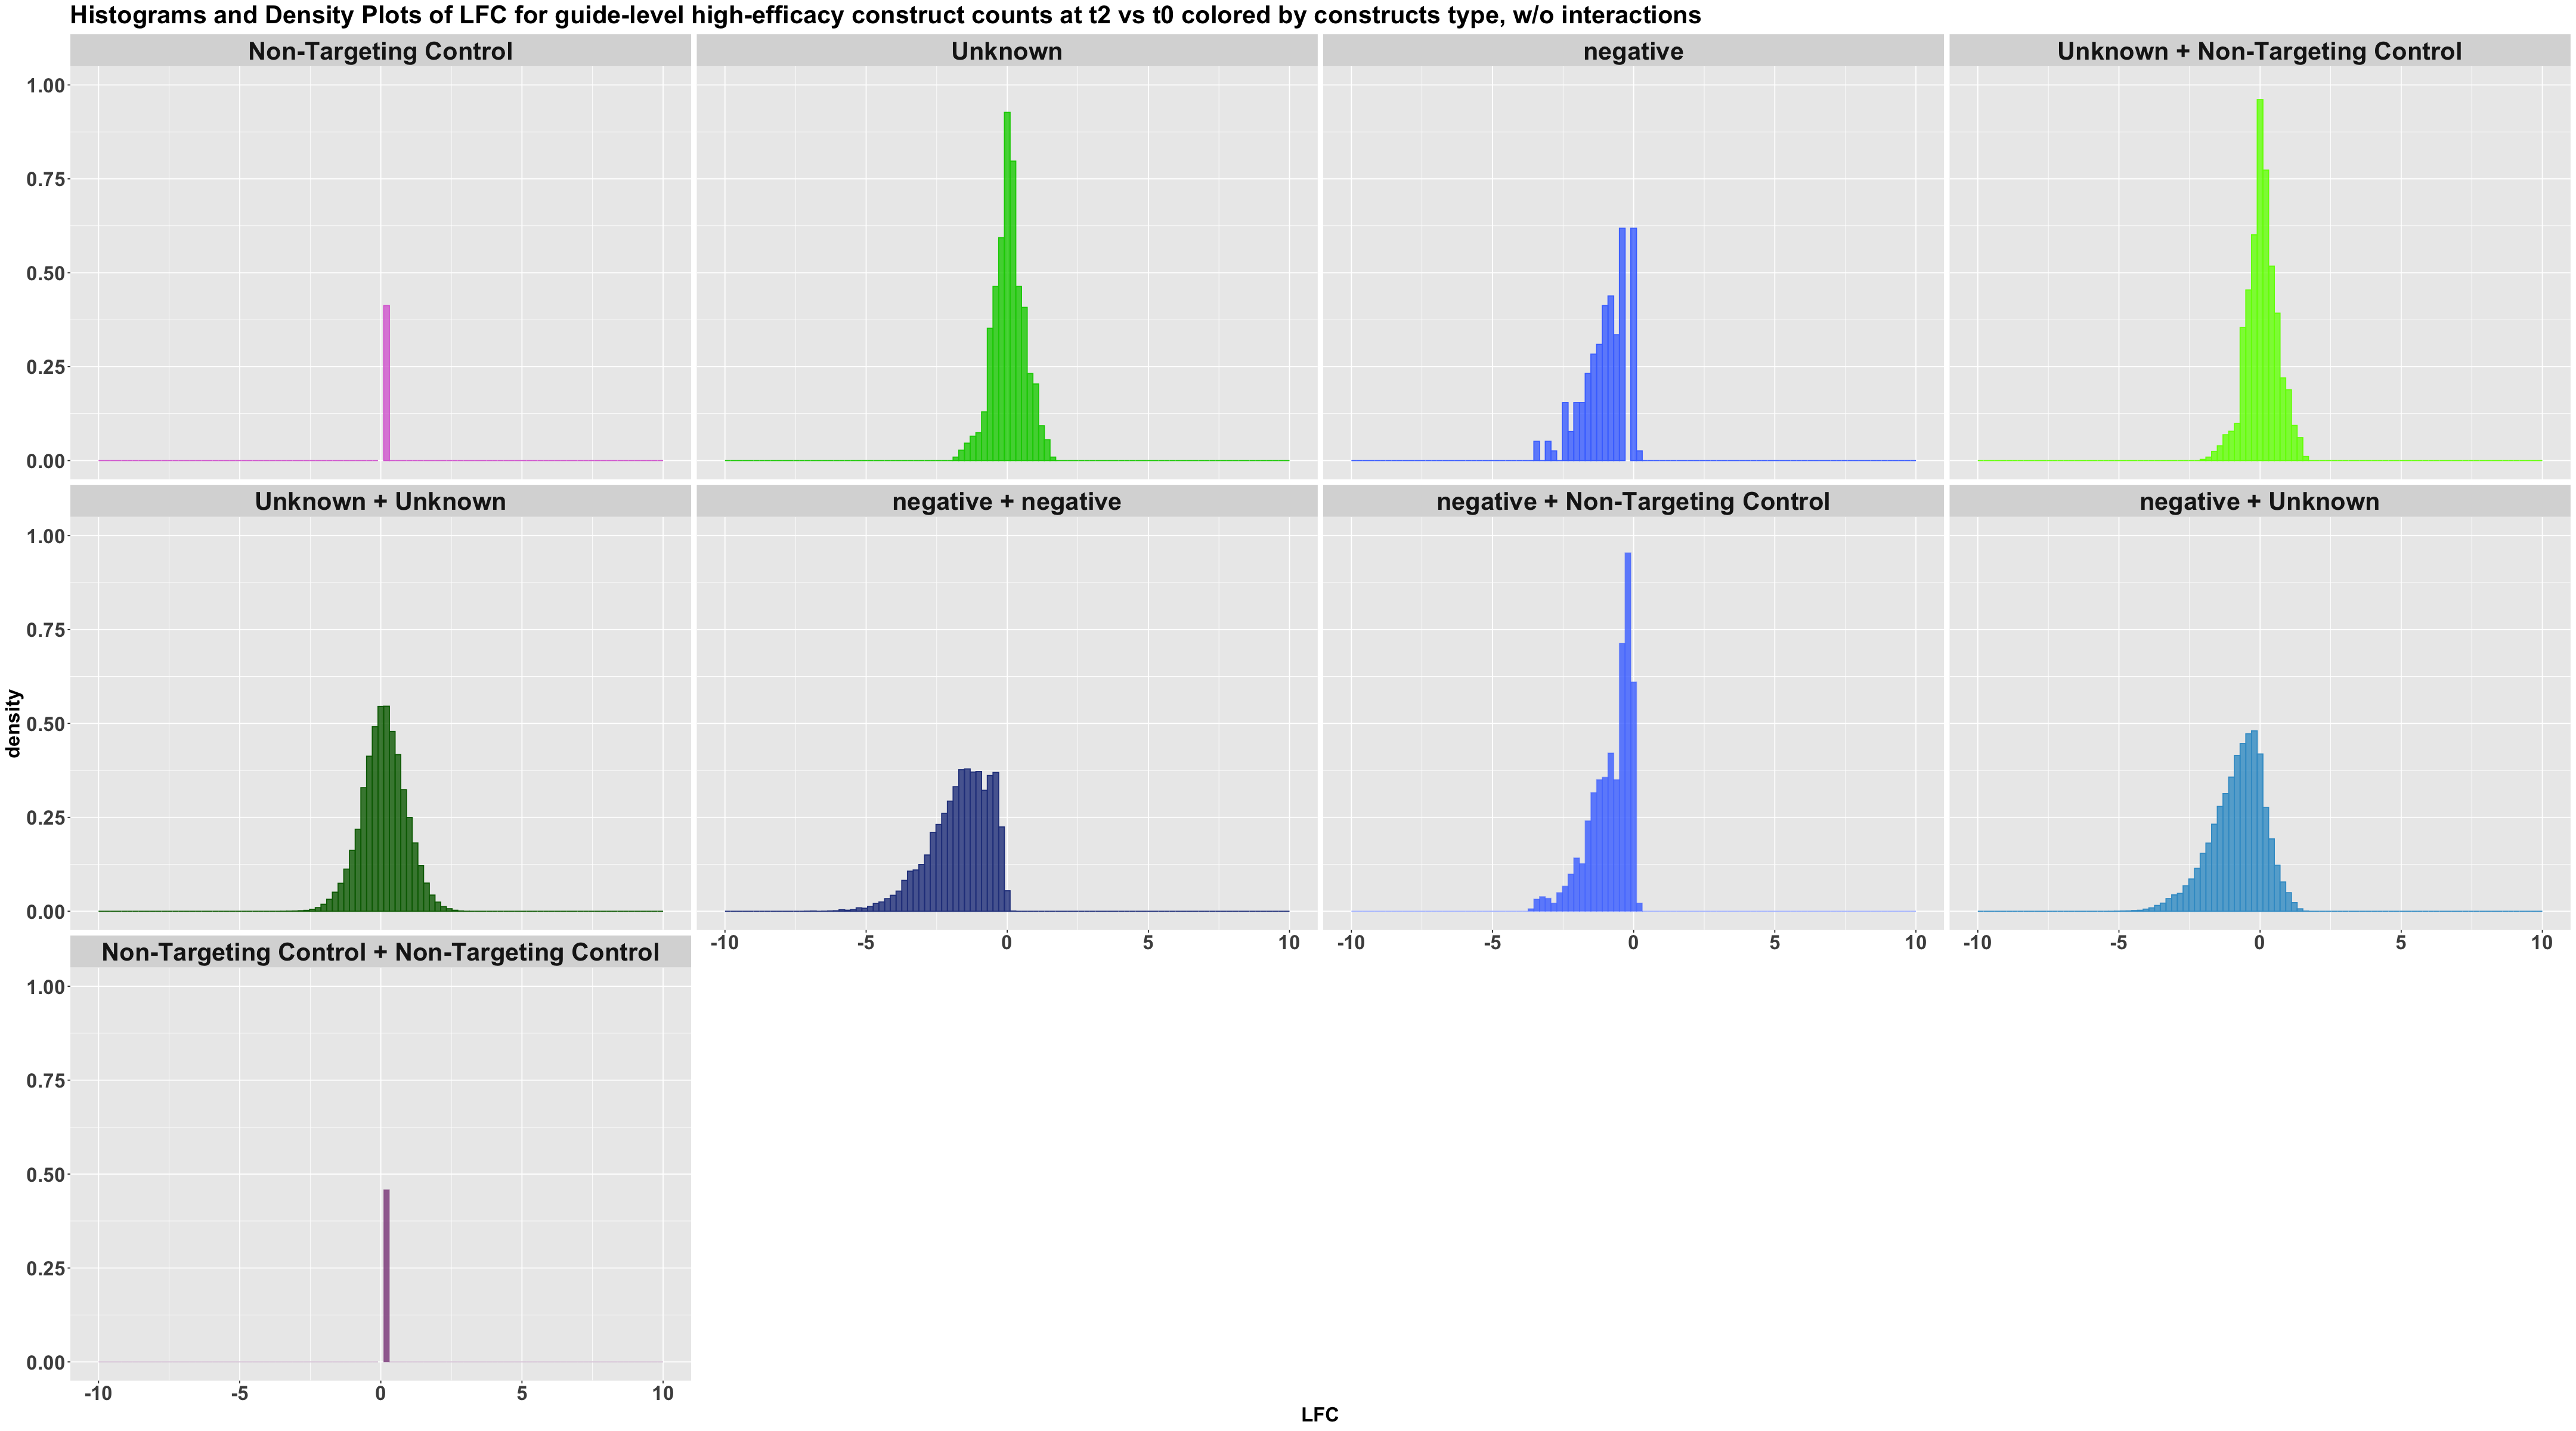

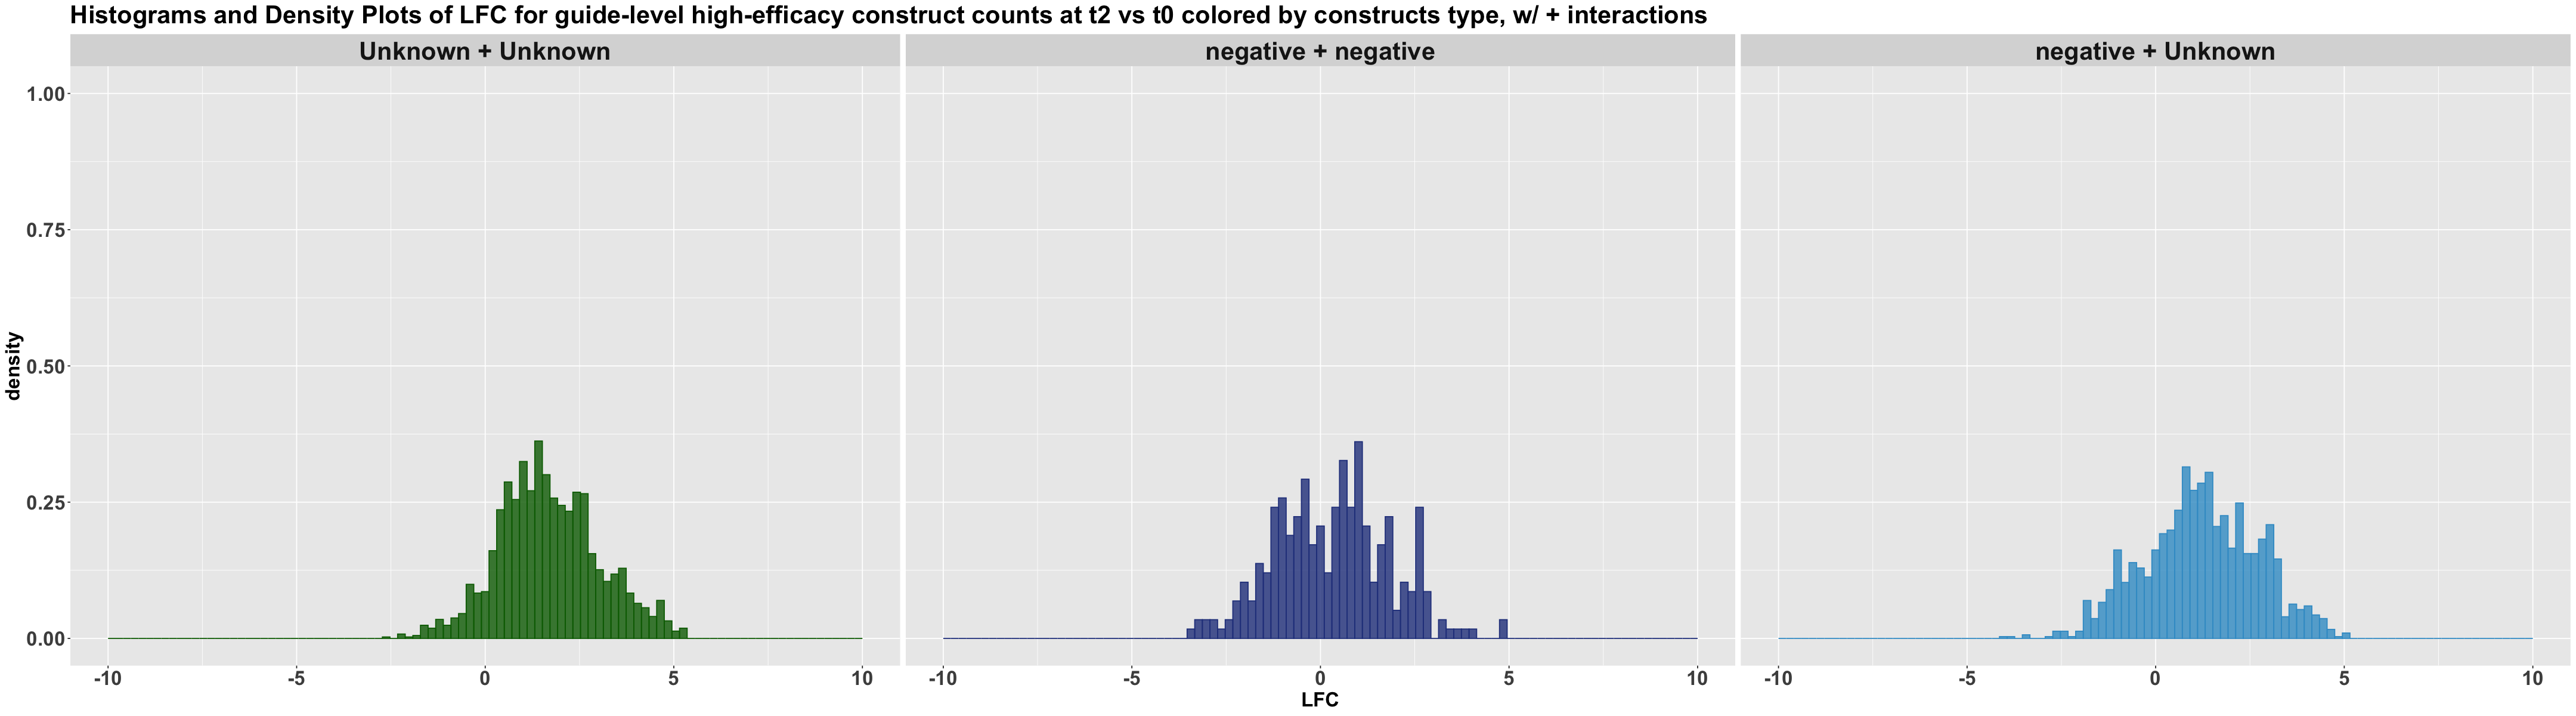

In [21]:
# 4. visualize LFC histogram and density plot for DKO combinations of different gene classes
## adjust xrange and yrange accordingly
xrange = c(-10,10)
yrange = c(0, 1)
## adjust gene class colors accordingly
group_colors = c("WT"="green3", "negative"="royalblue", "positive"="brown1", "Non-Targeting Control"="orchid")
group_color2 = c("Unknown"="green3", "negative"="royalblue1", "positive"="brown1", "Non-Targeting Control"="orchid",
                 "Unknown + Non-Targeting Control"="#6fff00", "Unknown + Unknown"="#016901", 
                 "negative + Non-Targeting Control"="#4876ff77", "negative + Unknown"="#3a9ccd", "negative + positive"="#3f1a7b86", "negative + negative"="royalblue4", 
                 "positive + Non-Targeting Control"="#ee3b3b66", "positive + Unknown"="#cd8630", "positive + positive"="brown4", 
                 "Non-Targeting Control + Non-Targeting Control"="#8b47894c")
## modify text format and size
theme_text = theme(
        plot.title = element_text(size = 25, face = "bold"),   # Title size, add 'face = "bold"' if needed'
        axis.title.x = element_text(size = 20, face = "bold"),  # X-axis title
        axis.title.y = element_text(size = 20, face = "bold"),  # Y-axis title
        axis.text.x = element_text(size = 20, face = "bold"),   # X-axis text
        axis.text.y = element_text(size = 20, face = "bold"),   # Y-axis text
        legend.title = element_text(size = 20, face = "bold"),  # Legend title
        legend.text = element_text(size = 20, face = "bold"),   # Legend text
        strip.text = element_text(size = 25, face = "bold")     # Facet labels
    )

# for all guides - hide color and fill legend
plot_guide_gi7 = ggplot(cell_lib_guide2 %>% filter(interaction_gene_type == "negative"), aes(x=LFC, fill = construct_type, color = construct_type)) +
        geom_histogram(aes(y=..density..), alpha = 0.8, bins = 100, position = "identity") +
        scale_x_continuous(limits = xrange) +
        scale_y_continuous(limits = yrange) +
        scale_fill_manual(values = group_color2, name = "KO Gene Behavior") +
        scale_color_manual(values = group_color2, name = "KO Gene Behavior") +
        facet_wrap(~construct_type, ncol = 4) +
        ggtitle("Histograms and Density Plots of LFC for guide-level high-efficacy construct counts at t2 vs t0 colored by constructs type, w/ - interactions") +
        guides(color = "none", fill = "none") +
        theme_text
plot_guide_gi8 = ggplot(cell_lib_guide2 %>% filter(interaction_gene_type == "none"), aes(x=LFC, fill = construct_type, color = construct_type)) +
        geom_histogram(aes(y=..density..), alpha = 0.8, bins = 100, position = "identity") +
        scale_x_continuous(limits = xrange) +
        scale_y_continuous(limits = yrange) +
        scale_fill_manual(values = group_color2, name = "KO Gene Behavior") +
        scale_color_manual(values = group_color2, name = "KO Gene Behavior") +
        facet_wrap(~construct_type, ncol = 4) +
        ggtitle("Histograms and Density Plots of LFC for guide-level high-efficacy construct counts at t2 vs t0 colored by constructs type, w/o interactions") +
        guides(color = "none", fill = "none") +
        theme_text
plot_guide_gi9 = ggplot(cell_lib_guide2 %>% filter(interaction_gene_type == "positive"), aes(x=LFC, fill = construct_type, color = construct_type)) +
        geom_histogram(aes(y=..density..), alpha = 0.8, bins = 100, position = "identity") +
        scale_x_continuous(limits = xrange) +
        scale_y_continuous(limits = yrange) +
        scale_fill_manual(values = group_color2, name = "KO Gene Behavior") +
        scale_color_manual(values = group_color2, name = "KO Gene Behavior") +
        facet_wrap(~construct_type, ncol = 4) +
        ggtitle("Histograms and Density Plots of LFC for guide-level high-efficacy construct counts at t2 vs t0 colored by constructs type, w/ + interactions") +
        guides(color = "none", fill = "none") +
        theme_text

options(repr.plot.width = 27, repr.plot.height = 5)
plot_guide_gi7
options(repr.plot.width = 36, repr.plot.height = 20)
plot_guide_gi8
options(repr.plot.width = 36, repr.plot.height = 10)
plot_guide_gi9

## PART 3: dLFC (Dede et al., 2020) Application


### “Single mutant/knockout fitness, SMF, for each gene was calculated as the mean construct fold change of gene-control constructs, for both A and B position.” ([Dede et al., 2020, p. 16](zotero://select/library/items/B28CE92S)) ([pdf](zotero://open-pdf/library/items/PWVMJQVC?page=16&annotation=XC7Q6Q8S)) “Difference in log fold change for a gene pair (dLFC) was calculated as observation, the mean LFC of all constructs targeting the gene pair, minus expectation, the sum of the SMF for the two genes.” ([Dede et al., 2020, p. 16](zotero://select/library/items/B28CE92S)) ([pdf](zotero://open-pdf/library/items/PWVMJQVC?page=16&annotation=EYHMBIRY))

In [23]:
# check sample name
print(sample_name)

[1] "DKOsim_mimic_fong2024"


In [24]:
# R kernal
library(gemini)
library(readxl)
library(stringr)
library(data.table)
library(parallel)
library(MASS)
library(corrplot)
library(psych)
library(ggtext)
library(tidyverse)
library(dplyr)
library(grid)
library(gridExtra)

# read data from hpc
cell_lib_guide2_A = read.csv(paste0("./data/", sample_name, "_", "repA.csv")) %>% 
  dplyr::select(-X)

cell_lib_guide2_B = read.csv(paste0("./data/", sample_name, "_", "repB.csv")) %>% 
  dplyr::select(-X) %>% 
  dplyr::select(guide_id, counts_guide_t0, counts_guide_t1, counts_guide_t2, rel_freq_guide_t0, rel_freq_guide_t2, LFC)

cell_lib_guide2 = merge(cell_lib_guide2_A, cell_lib_guide2_B, by = "guide_id") %>% 
  dplyr::rename(counts_guide_t0_1 = counts_guide_t0.x,
                counts_guide_t0_2 = counts_guide_t0.y,
                counts_guide_t1_1 = counts_guide_t1.x,
                counts_guide_t1_2 = counts_guide_t1.y,
                counts_guide_t2_1 = counts_guide_t2.x,
                counts_guide_t2_2 = counts_guide_t2.y,
                rel_freq_guide_t0_1 = rel_freq_guide_t0.x,
                rel_freq_guide_t0_2 = rel_freq_guide_t0.y,
                rel_freq_guide_t2_1 = rel_freq_guide_t2.x,
                rel_freq_guide_t2_2 = rel_freq_guide_t2.y,
                LFC_t2_1 = LFC.x,
                LFC_t2_2 = LFC.y) %>% 
  mutate(guide1_type = ifelse(guide1_type == 1, "high", "low"),
         guide2_type = ifelse(guide2_type == 1, "high", "low"),
         construct_type = ifelse(is.na(gene2_behavior), gene1_behavior,
                                 paste0(gene1_behavior, " + ", gene2_behavior)),
         LFC_t2_1 = log2(((rel_freq_guide_t2_1 + pseudo_counts) / (rel_freq_guide_t0_1 + pseudo_counts))),
         LFC_t2_2 = log2(((rel_freq_guide_t2_2 + pseudo_counts) / (rel_freq_guide_t0_2 + pseudo_counts))))%>% 
  mutate(LFC = (LFC_t2_1 + LFC_t2_2)/2) # aggregate the LFC between 2 replicates by averaging


# read the simulated data and prepare sample name
sim_data = cell_lib_guide2 %>%
  mutate(construct_type = ifelse(KO_type == "SKO", "SKO",
                                 ifelse(gene1_behavior == "Non-Targeting Control" | gene2_behavior == "Non-Targeting Control", "SKO", "DKO" )))

nc_gene = unique(as.character(filter(sim_data, gene1_behavior == "Non-Targeting Control")$gene1))

Warning message:
"package 'readxl' was built under R version 4.3.3"
Warning message:
"package 'data.table' was built under R version 4.3.3"

Attaching package: 'data.table'


The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from 'package:purrr':

    transpose


The following objects are masked from 'package:dplyr':

    between, first, last


Warning message:
"package 'corrplot' was built under R version 4.3.3"
corrplot 0.95 loaded

Warning message:
"package 'psych' was built under R version 4.3.3"

Attaching package: 'psych'


The following objects are masked from 'package:scales':

    alpha, rescale


The following object is masked from 'package:gtools':

    logit


The following objects are masked from 'package:ggplot2':

    %+%, alpha



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


The following o

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


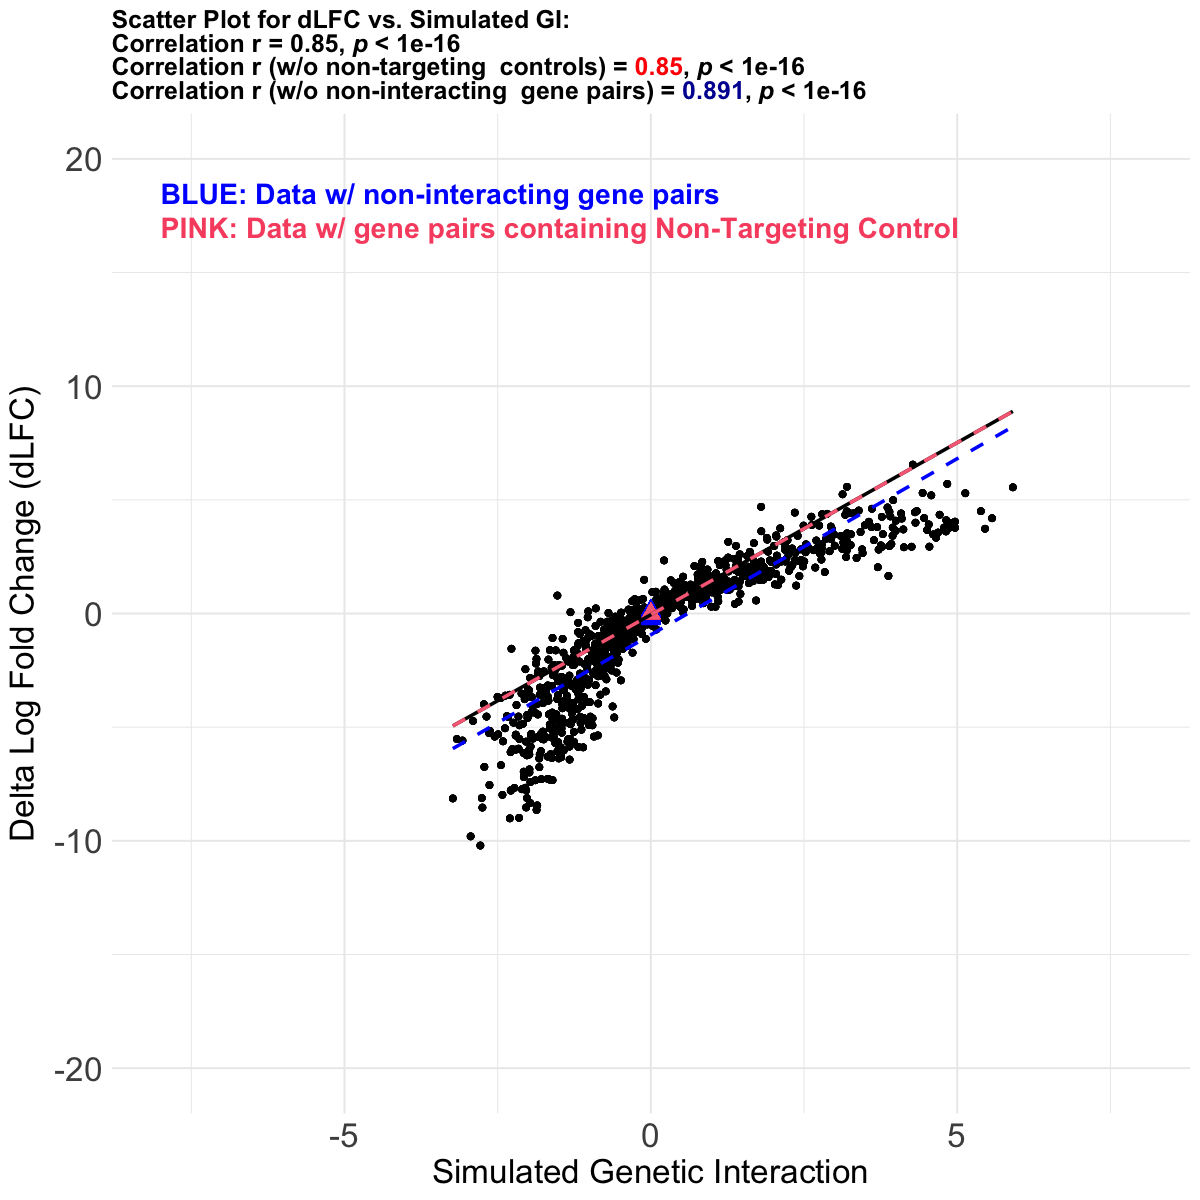

In [26]:
# scatterplot for dLFC vs simulated GIs
xlim = c(-8,8)
ylim = c(-20,20)
# calculate single mutant/knockout fitness
gene_SMF = sim_data %>% 
  filter(construct_type == "SKO", gene1_behavior != "Non-Targeting Control") %>% 
  group_by(gene1) %>% 
  dplyr::summarise(SMF = mean(LFC))
# calculate mean LFC for gene pairs that don't contain control
gene_LFC = sim_data %>% 
  filter(construct_type == "DKO") %>% 
  group_by(gene_pair_id) %>% 
  dplyr::summarise(LFC_mean = mean(LFC))
# calculate dLFC = LFC_mean - (SMF1 + SMF2)
sim_data_dLFC = left_join(sim_data, gene_SMF, by = "gene1") %>% 
  dplyr::rename(gene1_SMF = SMF) %>% 
  left_join(gene_SMF, by = c("gene2"="gene1")) %>% 
  dplyr::rename(gene2_SMF = SMF) %>% 
  left_join(gene_LFC, by = "gene_pair_id") %>% 
  mutate(gene1_SMF = ifelse(is.na(gene1_SMF), 0, gene1_SMF),
         gene2_SMF = ifelse(is.na(gene2_SMF), 0, gene2_SMF),
         LFC_mean = ifelse(construct_type == "SKO",
                           ifelse(gene1_SMF == 0, gene2_SMF, gene1_SMF), LFC_mean)) %>% 
  mutate(dLFC = LFC_mean - (gene1_SMF+gene2_SMF))

# add data frame for the non-control group
control = sim_data_dLFC %>% filter(gene1 %in% nc_gene | gene2 %in% nc_gene)
sim_dLFC_noncontrol = sim_data_dLFC %>% anti_join(control, by = "gene1_gene2_id")
# add data frame for the non-interacting group
control0 = sim_data_dLFC %>% filter(interaction_gene == 0)
sim_dLFC_noncontrol0 = sim_data_dLFC %>% anti_join(control0, by = "gene1_gene2_id")

# compute correlation and p-values
cor_test_all <- cor.test(sim_data_dLFC$interaction_gene, sim_data_dLFC$dLFC, method = "pearson")
cor_test_noncontrol <- cor.test(sim_dLFC_noncontrol$interaction_gene, sim_dLFC_noncontrol$dLFC, method = "pearson")
cor_test_noncontrol0 <- cor.test(sim_dLFC_noncontrol0$interaction_gene, sim_dLFC_noncontrol0$dLFC, method = "pearson")
# define a function to format p-values if p-values are extremely small
format_p <- function(pval) {
  if (is.na(pval)) return("NA")
  if (pval < 1e-16) {
    return("< 1e-16")
  } else {
    return(formatC(pval, format = "e", digits = 2))
  }
}
# plot the scatterplot
theme_text = theme(
  plot.title = element_markdown(size = 15, face = "bold"),   # Title size, add 'face = "bold"' if needed'
  axis.title.x = element_text(size = 20),  # X-axis title
  axis.title.y = element_text(size = 20),  # Y-axis title
  axis.text.x = element_text(size = 20),   # X-axis text
  axis.text.y = element_text(size = 20),   # Y-axis text
  legend.title = element_text(size = 20),  # Legend title
  legend.text = element_text(size = 20),   # Legend text
  strip.text = element_text(size = 30)     # Facet labels
)
scatterplot_dlfc = ggplot(sim_data_dLFC, aes(x = interaction_gene, y = dLFC)) +
  geom_point(alpha = 0.7, color = "black") +
  geom_point(data = control0, aes(x = interaction_gene, y = dLFC), 
             size = 3, shape = 17, color = "blue", fill = "yellow", stroke = 1.5) +
  geom_point(data = control, aes(x = interaction_gene, y = dLFC), 
             size = 3, shape = 17, color = "#f76d84", fill = "yellow", stroke = 1.5) +
  # Regression line for all data
  geom_smooth(method = "lm", col = "black", se = FALSE, linetype = "solid") + 
  # Regression line for non-control data
  geom_smooth(data = sim_dLFC_noncontrol, aes(x = interaction_gene, y = dLFC), 
              method = "lm", col = "#f76d84", se = FALSE, linetype = "dashed") + 
  # Regression line for non-zero genetic interactions data
  geom_smooth(data = sim_dLFC_noncontrol0, aes(x = interaction_gene, y = dLFC), 
              method = "lm", col = "blue", se = FALSE, linetype = "dashed") + 
  ggtitle(paste0(
  "Scatter Plot for dLFC vs. Simulated GI:<br>",
  "Correlation r = ", round(cor_test_all$estimate, 3), 
  ", *p* ", format_p(cor_test_all$p.value), "<br>",
  "Correlation r (w/o non-targeting  controls) = <span style='color:red;'>", round(cor_test_noncontrol$estimate, 3),
  "</span>, *p* ", format_p(cor_test_noncontrol$p.value), "<br>",
  "Correlation r (w/o non-interacting  gene pairs) = <span style='color:#0404a0;'>", round(cor_test_noncontrol0$estimate, 3), 
  "</span>, *p* ", format_p(cor_test_noncontrol0$p.value))) +
  labs(color = "Gene-gene Interaction Type") +
  guides(color = guide_legend(override.aes = list(size = 5))) +
  ylim(ylim[1],ylim[2])+
  xlim(xlim[1],xlim[2])+
  theme_minimal() +
  xlab("Simulated Genetic Interaction") +
  ylab("Delta Log Fold Change (dLFC)") +
  # Add annotation label for control points
  annotate("text", x = xlim[1], 
           y = ylim[2]-3, 
           label = "PINK: Data w/ gene pairs containing Non-Targeting Control", 
           color = "#f85470", size = 6, hjust = 0, fontface = "bold") +
  # Add annotation label for non-interacting points
  annotate("text", x = xlim[1], 
           y = ylim[2]-1.5, 
           label = "BLUE: Data w/ non-interacting gene pairs", 
           color = "blue", size = 6, hjust = 0, fontface = "bold")  +
  theme_text

# show the plot
options(repr.plot.width = 10, repr.plot.height = 10)
scatterplot_dlfc

In [28]:
# write out the dlfc data
write.csv(sim_data_dLFC, paste0("./data/", sample_name, "_dLFC.csv"), row.names = FALSE)

### Plot the PR curve

In [29]:
print(sample_name)

[1] "DKOsim_mimic_fong2024"


Rows: 271953 Columns: 65
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (12): gene1_gene2_id, guide1_id, guide2_id, construct_id, KO_type, gene1...
dbl (53): guide_id, gene_pair_id, gene1, gene2, guide1_eff, guide2_eff, p1, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 271953 Columns: 65
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (12): gene1_gene2_id, guide1_id, guide2_id, construct_id, KO_type, gene1...
dbl (53): guide_id, gene_pair_id, gene1, gene2, guide1_eff, guide2_eff, p1, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


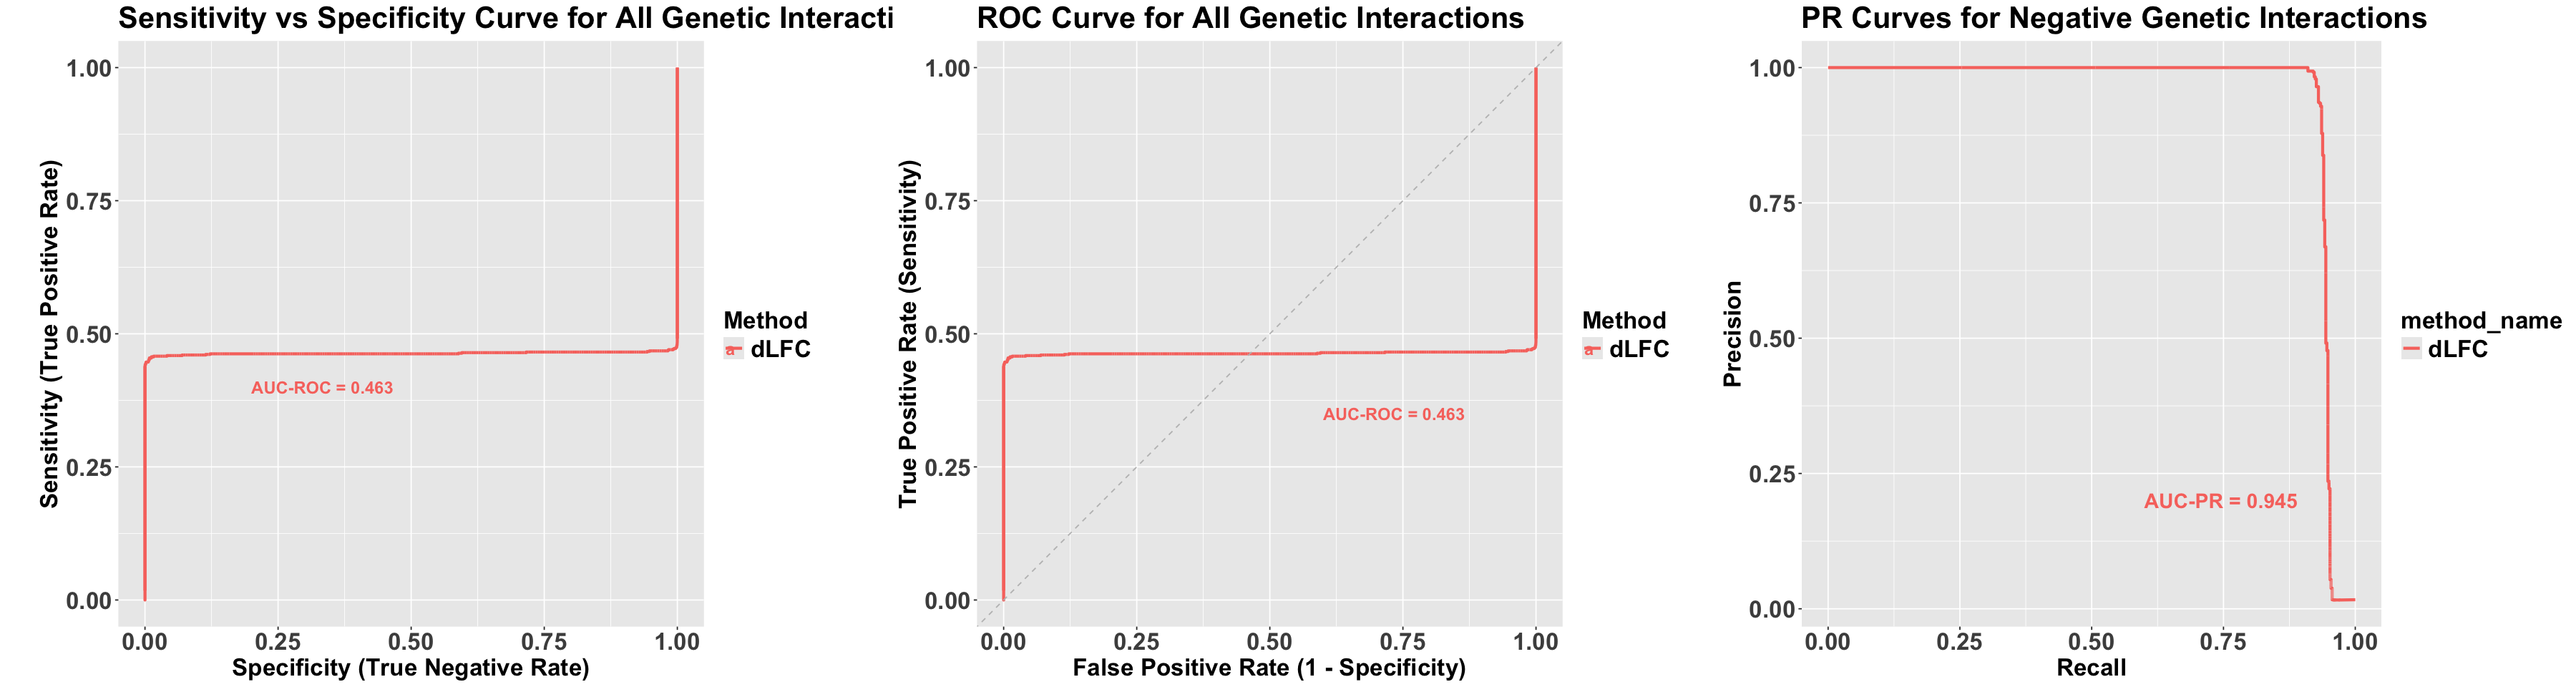

In [32]:
# sensitivity and specificity curve
library(yardstick)
# modify text size
theme_text = theme(
        plot.title = element_text(size = 25, face = "bold"),   # Title size, add 'face = "bold"' if needed'
        axis.title.x = element_text(size = 20, face = "bold"),  # X-axis title
        axis.title.y = element_text(size = 20, face = "bold"),  # Y-axis title
        axis.text.x = element_text(size = 20, face = "bold"),   # X-axis text
        axis.text.y = element_text(size = 20, face = "bold"),   # Y-axis text
        legend.title = element_text(size = 20, face = "bold"),  # Legend title
        legend.text = element_text(size = 20, face = "bold"),   # Legend text
        strip.text = element_text(size = 25, face = "bold")     # Facet labels
    )

# 1. plot the Sensitivity and specificity curve for dLFC on genetic interactions
sim_data_gemini_dlfc_pr_sl = read_csv(paste0("./data/", sample_name, "_dLFC.csv"))

# Label top hits
sim_data_top_label <- sim_data_gemini_dlfc_pr_sl %>%
  mutate(top_hit = if_else(i_interaction != 0, "yes", "no")) %>%
  mutate(top_hit = factor(top_hit, levels = c("yes", "no"))) %>% 
  dplyr::select(construct_id,gene_pair_id, top_hit, dLFC) %>% 
  pivot_longer(cols = dLFC,
               names_to = "method_name",
               values_to = "pred_hit")

# 🛠️ Step: keep only one row per gene_pair per method
sim_data_pair_level <- sim_data_top_label %>%
  distinct(gene_pair_id, method_name, pred_hit, top_hit)

sens_spec_data <- sim_data_pair_level %>%
  group_by(method_name) %>%
  yardstick::roc_curve(truth = top_hit, pred_hit) %>%
  mutate(
    specificity = 1 - specificity,  # because "specificity" column is actually FPR
    sensitivity = sensitivity       # TPR is already provided
  )
# add AUC-ROC to the plot
auc_roc <- sim_data_pair_level %>%
  group_by(method_name) %>%
  roc_auc(truth = top_hit, pred_hit)
annot_df <- auc_roc %>%
  dplyr::mutate(
    label = paste0("AUC-ROC = ", round(.estimate, 3)),
    x = 0.2,  # x-coordinate of the label
    y = seq(0.4, 0.5, length.out = n())  # stagger vertically
  )

### 1. Plot Sensitivity vs Specificity
plot_sens1 = ggplot(sens_spec_data, aes(x = specificity, y = sensitivity, color = method_name)) +
  geom_line(size = 1.2) +
  geom_text(data = annot_df,
            aes(x = x, y = y, label = label, color = method_name),
            inherit.aes = FALSE,
            size = 5, fontface = "bold", hjust = 0) +
  labs(
    title = "Sensitivity vs Specificity Curve for All Genetic Interactions",
    x = "Specificity (True Negative Rate)",
    y = "Sensitivity (True Positive Rate)",
    color = "Method"
  ) +
  coord_equal() +
  scale_x_continuous(limits = c(0, 1)) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_text

# ROC curve
roc_data <- sim_data_pair_level %>%
  group_by(method_name) %>%
  yardstick::roc_curve(truth = top_hit, pred_hit) %>%
  mutate(fpr = 1 - specificity,
         tpr = sensitivity)  # Convert specificity to FPR

# Compute AUC-ROC
auc_roc <- sim_data_pair_level %>%
  group_by(method_name) %>%
  roc_auc(truth = top_hit, pred_hit)

# Prepare annotation text
annot_df <- auc_roc %>%
  dplyr::mutate(
    label = paste0("AUC-ROC = ", round(.estimate, 3)),
    x = 0.6,
    y = seq(0.35, 0.4, length.out = n())
  )

### 2. Plot ROC curve
plot_roc1 =ggplot(roc_data, aes(x = fpr, y = tpr, color = method_name)) +
  geom_line(size = 1.2) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  geom_text(data = annot_df,
            aes(x = x, y = y, label = label, color = method_name),
            inherit.aes = FALSE,
            size = 5, fontface = "bold", hjust = 0) +
  labs(
    title = "ROC Curve for All Genetic Interactions",
    x = "False Positive Rate (1 - Specificity)",
    y = "True Positive Rate (Sensitivity)",
    color = "Method"
  ) +
  coord_equal() +
  scale_x_continuous(limits = c(0, 1)) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_text

# 3. PR curve data - for all negative interactions (SL)
library(dplyr)

sim_data_gemini_dlfc_pr_sl = read_csv(paste0("./data/", sample_name, "_dLFC.csv")) %>% 
  filter(interaction_gene_type == "negative" | interaction_gene_type == "none")

# label pred_hit by i_interaction
sim_data_label <- sim_data_gemini_dlfc_pr_sl %>%
  mutate(top_hit = if_else(i_interaction != 0, "yes", "no")) %>%
  mutate(top_hit = factor(top_hit, levels = c("yes", "no"))) %>% 
  dplyr::select(construct_id,gene_pair_id, top_hit, dLFC) %>% 
  mutate(
    dLFC = -dLFC
  ) %>%
  pivot_longer(cols = dLFC,
               names_to = "method_name",
               values_to = "pred_hit")

# 🛠️ Step: keep only one row per gene_pair per method
sim_data_pair_level <- sim_data_label %>%
  distinct(gene_pair_id, method_name, pred_hit, top_hit)

library(yardstick)
# Compute PR curves
pr_data_top <- sim_data_pair_level %>%
  group_by(method_name) %>%
  pr_curve(truth = top_hit, pred_hit)

# Compute AUC-PR values
auc_pr_data_top <- sim_data_pair_level %>%
  group_by(method_name) %>%
  average_precision(truth = top_hit, pred_hit)

library(ggplot2)
# Prepare data for annotations
combined_metrics_top <- auc_pr_data_top %>%
  dplyr::mutate(y_pos = seq(0.2, 0.4, length.out = n()))

# Plot PR curves
plot_pr <- ggplot(pr_data_top, aes(x = recall, y = precision, color = method_name)) +
  geom_line(size = 1.2) +
  geom_text(data = combined_metrics_top,
            aes(x = 0.6, y = y_pos,
                label = paste0("AUC-PR = ", round(.estimate, 3)),
                color = method_name),
            size = 6, fontface = "bold",
            inherit.aes = FALSE,
            show.legend = FALSE,
            hjust = 0) +
  labs(title = "PR Curves for Negative Genetic Interactions",
       x = "Recall", y = "Precision") +
  theme_text


options(repr.plot.width = 30, repr.plot.height = 8)
grid.arrange(arrangeGrob(plot_sens1, ncol=1),
             arrangeGrob(plot_roc1, ncol=1),
             arrangeGrob(plot_pr, ncol=1),
             ncol = 3)


Rows: 271953 Columns: 65
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (12): gene1_gene2_id, guide1_id, guide2_id, construct_id, KO_type, gene1...
dbl (53): guide_id, gene_pair_id, gene1, gene2, guide1_eff, guide2_eff, p1, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."


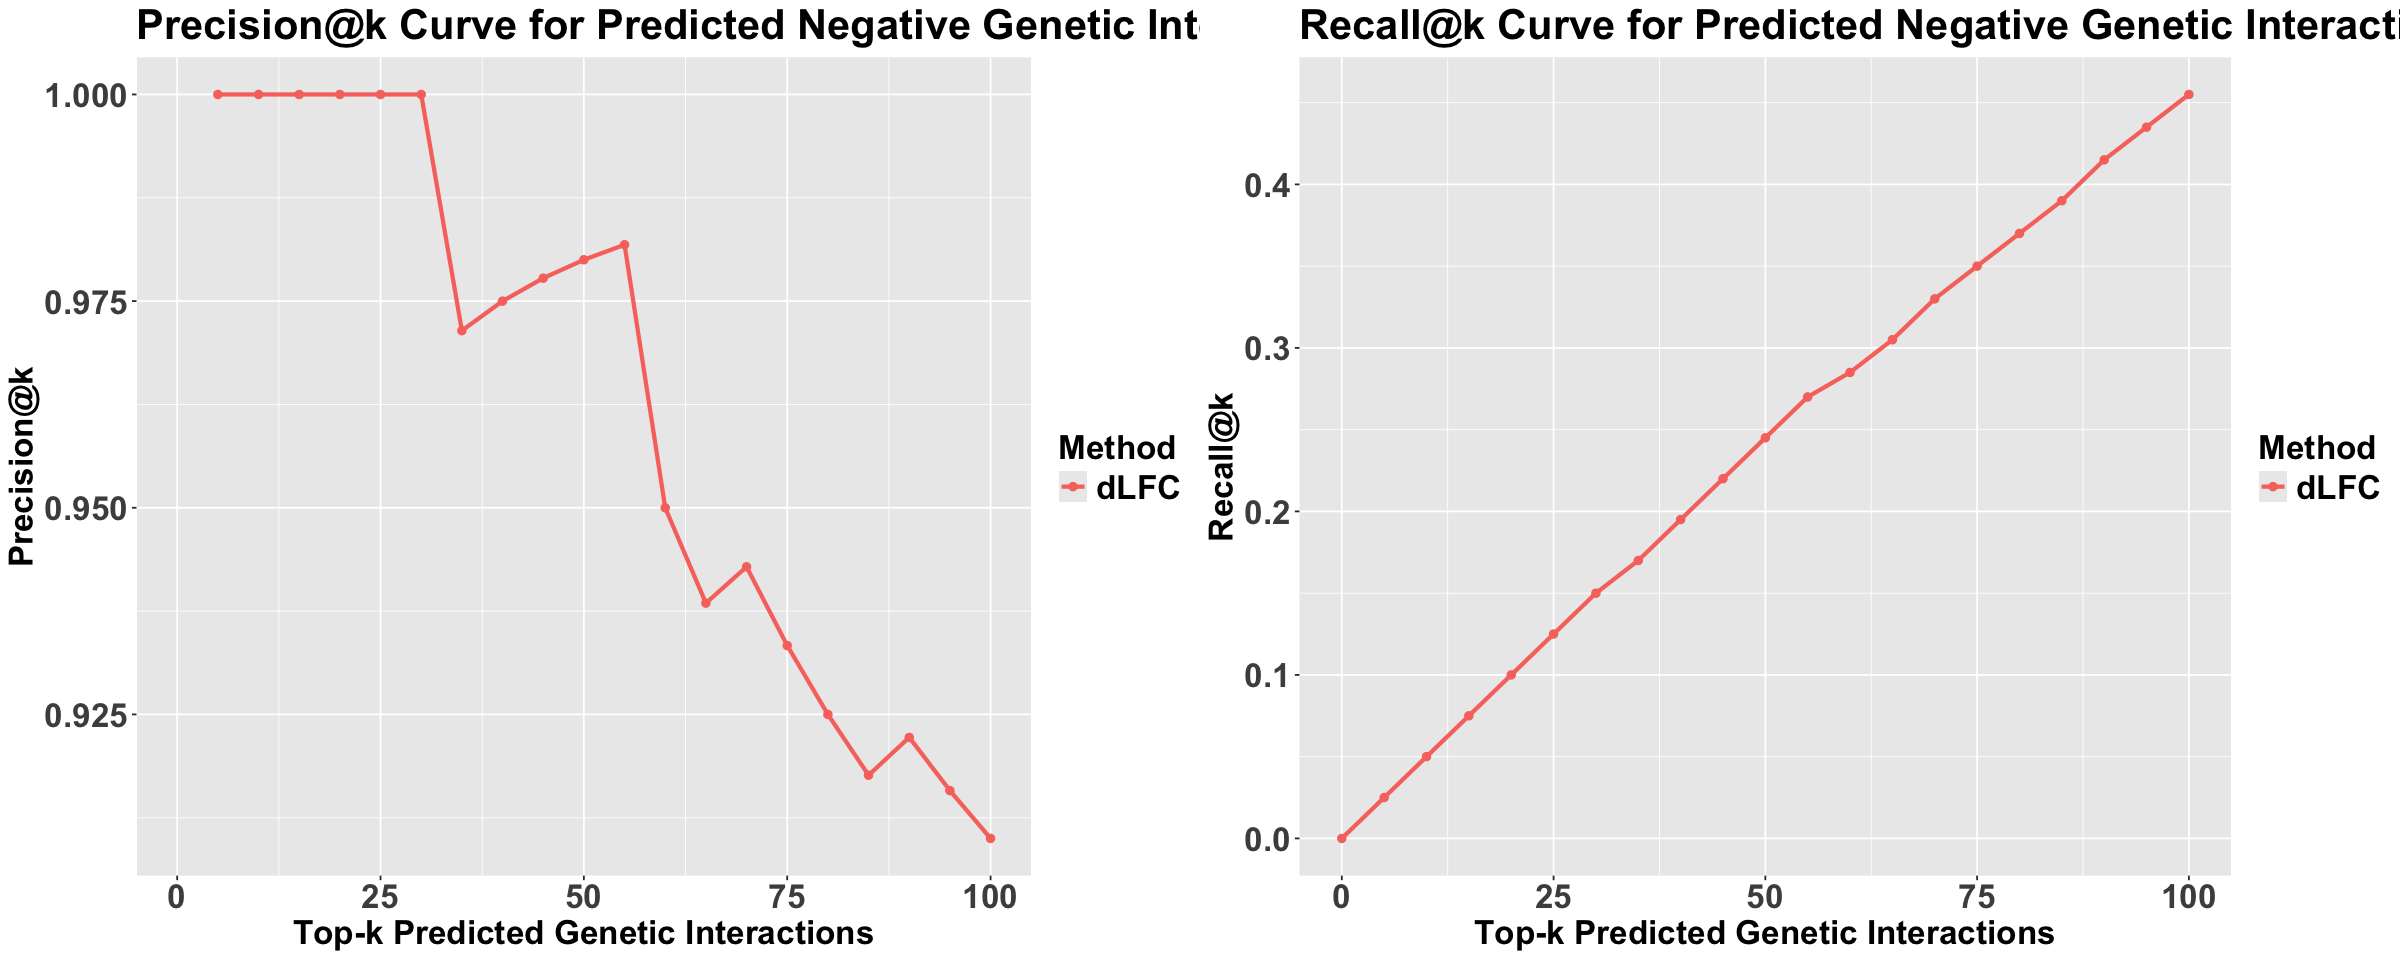

In [33]:
# top n-hits precision - precision @k curve
library(dplyr)
# Identify top 20 most negative interaction_gene values by uniquely gene_pairs
sim_data_gemini_dlfc_pr_sl = read_csv(paste0("./data/", sample_name, "_dLFC.csv"))

# Label top 500 strong negative simulated interactions
top_gene_pair_id <- sim_data_gemini_dlfc_pr_sl %>%
  distinct(gene_pair_id, .keep_all = TRUE) %>%
  slice_min(order_by = interaction_gene, n = 200, with_ties = F) %>%
  pull(gene_pair_id)

sim_data_top_label <- sim_data_gemini_dlfc_pr_sl %>%
  mutate(top_hit = if_else(gene_pair_id %in% top_gene_pair_id, "yes", "no")) %>%
  mutate(top_hit = factor(top_hit, levels = c("yes", "no"))) %>% 
  dplyr::select(construct_id,gene_pair_id, top_hit, dLFC) %>% 
  pivot_longer(cols = dLFC,
               names_to = "method_name",
               values_to = "pred_hit")

# 🛠️ Step: keep only one row per gene_pair per method
sim_data_pair_level <- sim_data_top_label %>%
  distinct(gene_pair_id, method_name, pred_hit, top_hit)

# Define the k values you want to evaluate
k_values <- seq(0, 100, by = 5)

# Compute Precision@k for both methods
precision_at_k <- sim_data_pair_level %>%
  group_by(method_name) %>%
  arrange(method_name, pred_hit) %>%  # increasing order — lower scores ranked higher
  dplyr::mutate(rank = row_number()) %>%
  dplyr::summarise(
    k = list(k_values),
    precision = list(sapply(k_values, function(k) {
      top_k <- top_hit[rank <= k]
      sum(top_k == "yes") / k
    })),
    .groups = "drop"
  ) %>%
  unnest(c(k, precision))

# Plot the Precision@k curve
plot_precision_k = ggplot(precision_at_k, aes(x = k, y = precision, color = method_name)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  labs(
    title = "Precision@k Curve for Predicted Negative Genetic Interactions",
    x = "Top-k Predicted Genetic Interactions",
    y = "Precision@k",
    color = "Method"
  ) +
  theme_text

# also add the Recall@100 calculation with plots
# Total number of true positives
total_positives <- sum(sim_data_pair_level$top_hit == "yes")

# Compute Recall@k
recall_at_k <- sim_data_pair_level %>%
  group_by(method_name) %>%
  arrange(method_name, pred_hit) %>%  # lower scores = higher rank
  dplyr::mutate(rank = row_number()) %>%
  dplyr::summarise(
    k = list(k_values),
    recall = list(sapply(k_values, function(k) {
      sum(top_hit[rank <= k] == "yes") / total_positives
    })),
    .groups = "drop"
  ) %>%
  unnest(c(k, recall))
# Plot the Recall@k curve
plot_recall_k <- ggplot(recall_at_k, aes(x = k, y = recall, color = method_name)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  labs(
    title = "Recall@k Curve for Predicted Negative Genetic Interactions",
    x = "Top-k Predicted Genetic Interactions",
    y = "Recall@k",
    color = "Method"
  ) +
  theme_text

options(repr.plot.width = 20, repr.plot.height = 8)
grid.arrange(arrangeGrob(plot_precision_k, ncol=1),
             arrangeGrob(plot_recall_k, ncol=1),
             ncol = 2)
options(repr.plot.width = 12, repr.plot.height = 8)

In [34]:
# print out auc_roc, auc_pr, precision @100 values
cat(auc_roc$.estimate, auc_pr_data_top$.estimate, filter(precision_at_k, method_name == "dLFC", k == 100)$precision, filter(recall_at_k, method_name == "dLFC", k == 100)$recall, sep = "\t")

0.4632989	0.9453759	0.91	0.455

# dLFC by replicates

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


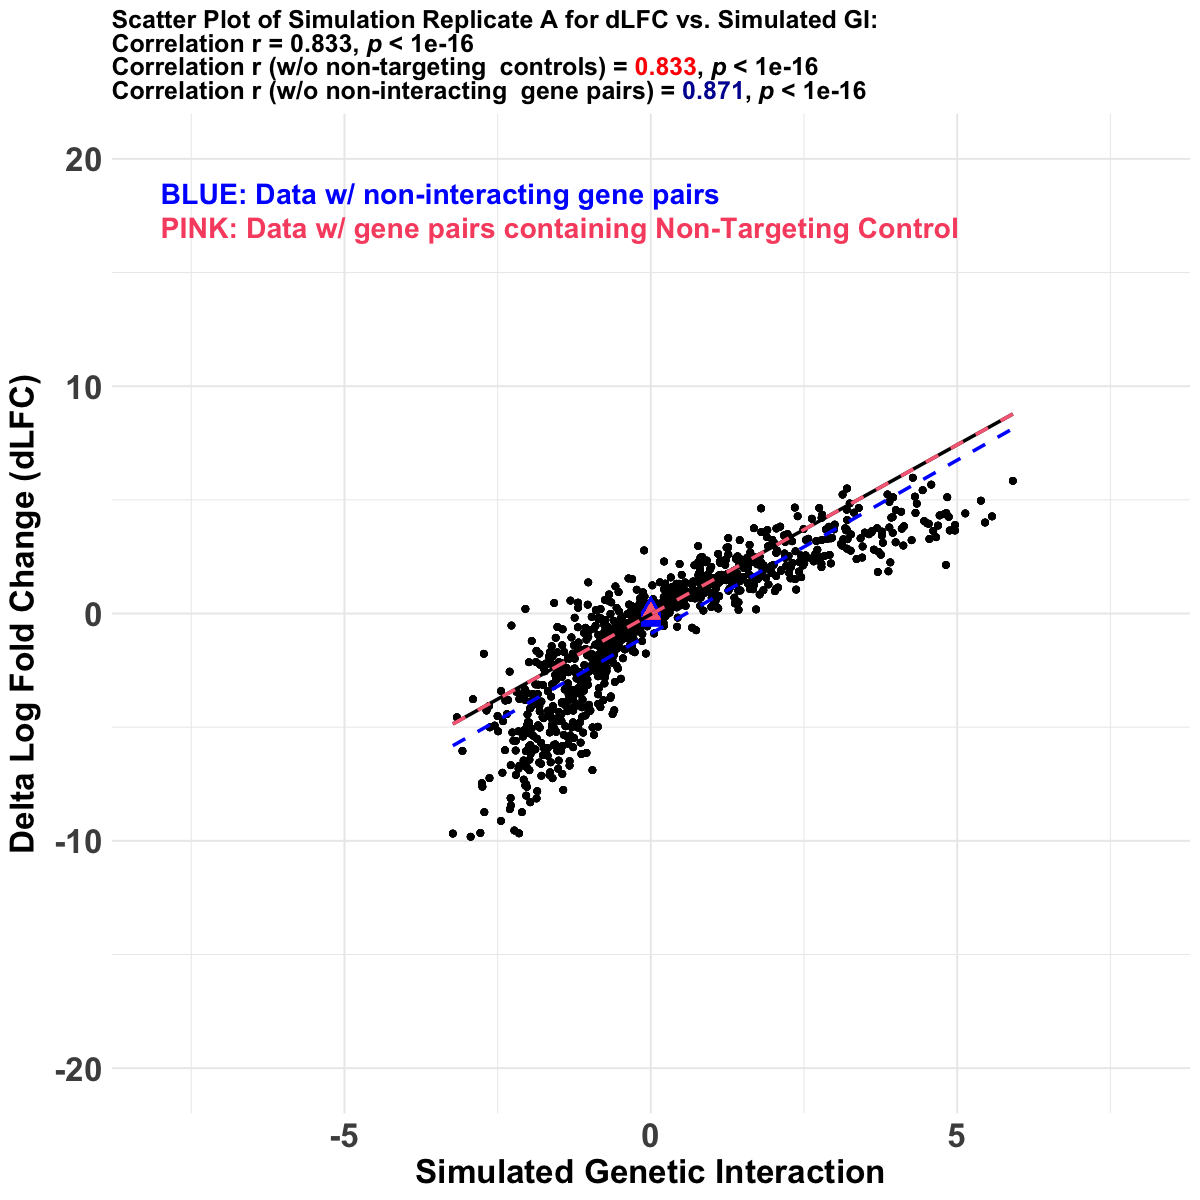

In [42]:
# swtich back to R kernal
library(gemini)
library(readxl)
library(stringr)
library(data.table)
library(parallel)
library(MASS)
library(corrplot)
library(psych)
library(ggtext)
library(tidyverse)
library(dplyr)
library(grid)
library(gridExtra)

# read data from hpc - replicate A only
sample_name = "DKOsim_mimic_fong2024"
pseudo_counts = 5e-9
cell_lib_guide2 = read.csv(paste0("./data/", sample_name, "_", "repA.csv")) %>% 
  dplyr::select(-X) %>% 
  mutate(guide1_type = ifelse(guide1_type == 1, "high", "low"),
         guide2_type = ifelse(guide2_type == 1, "high", "low"),
         construct_type = ifelse(is.na(gene2_behavior), gene1_behavior,
                                 paste0(gene1_behavior, " + ", gene2_behavior)),
         LFC = log2(((rel_freq_guide_t2 + pseudo_counts) / (rel_freq_guide_t0 + pseudo_counts))))


# read the simulated data and prepare sample name
sim_data = cell_lib_guide2 %>%
  mutate(construct_type = ifelse(KO_type == "SKO", "SKO",
                                 ifelse(gene1_behavior == "Non-Targeting Control" | gene2_behavior == "Non-Targeting Control", "SKO", "DKO" )))

nc_gene = unique(as.character(filter(sim_data, gene1_behavior == "Non-Targeting Control")$gene1))

# scatterplot for dLFC vs simulated GIs
xlim = c(-8,8)
ylim = c(-20,20)
# calculate single mutant/knockout fitness
gene_SMF = sim_data %>% 
  filter(construct_type == "SKO", gene1_behavior != "Non-Targeting Control") %>% 
  group_by(gene1) %>% 
  dplyr::summarise(SMF = mean(LFC))
# calculate mean LFC for gene pairs that don't contain control
gene_LFC = sim_data %>% 
  filter(construct_type == "DKO") %>% 
  group_by(gene_pair_id) %>% 
  dplyr::summarise(LFC_mean = mean(LFC))
# calculate dLFC = LFC_mean - (SMF1 + SMF2)
sim_data_dLFC = left_join(sim_data, gene_SMF, by = "gene1") %>% 
  dplyr::rename(gene1_SMF = SMF) %>% 
  left_join(gene_SMF, by = c("gene2"="gene1")) %>% 
  dplyr::rename(gene2_SMF = SMF) %>% 
  left_join(gene_LFC, by = "gene_pair_id") %>% 
  mutate(gene1_SMF = ifelse(is.na(gene1_SMF), 0, gene1_SMF),
         gene2_SMF = ifelse(is.na(gene2_SMF), 0, gene2_SMF),
         LFC_mean = ifelse(construct_type == "SKO",
                           ifelse(gene1_SMF == 0, gene2_SMF, gene1_SMF), LFC_mean)) %>% 
  mutate(dLFC = LFC_mean - (gene1_SMF+gene2_SMF))

# add data frame for the non-control group
control = sim_data_dLFC %>% filter(gene1 %in% nc_gene | gene2 %in% nc_gene)
sim_dLFC_noncontrol = sim_data_dLFC %>% anti_join(control, by = "gene1_gene2_id")
# add data frame for the non-interacting group
control0 = sim_data_dLFC %>% filter(interaction_gene == 0)
sim_dLFC_noncontrol0 = sim_data_dLFC %>% anti_join(control0, by = "gene1_gene2_id")

# compute correlation and p-values
cor_test_all <- cor.test(sim_data_dLFC$interaction_gene, sim_data_dLFC$dLFC, method = "pearson")
cor_test_noncontrol <- cor.test(sim_dLFC_noncontrol$interaction_gene, sim_dLFC_noncontrol$dLFC, method = "pearson")
cor_test_noncontrol0 <- cor.test(sim_dLFC_noncontrol0$interaction_gene, sim_dLFC_noncontrol0$dLFC, method = "pearson")
# define a function to format p-values if p-values are extremely small
format_p <- function(pval) {
  if (is.na(pval)) return("NA")
  if (pval < 1e-16) {
    return("< 1e-16")
  } else {
    return(formatC(pval, format = "e", digits = 2))
  }
}
# plot the scatterplot
theme_text = theme(
  plot.title = element_markdown(size = 15, face = "bold"),   # Title size, add 'face = "bold"' if needed'
  axis.title.x = element_text(size = 20, face = "bold"),  # X-axis title
  axis.title.y = element_text(size = 20, face = "bold"),  # Y-axis title
  axis.text.x = element_text(size = 20, face = "bold"),   # X-axis text
  axis.text.y = element_text(size = 20, face = "bold"),   # Y-axis text
  legend.title = element_text(size = 20),  # Legend title
  legend.text = element_text(size = 20),   # Legend text
  strip.text = element_text(size = 30)     # Facet labels
)
scatterplot_dlfc = ggplot(sim_data_dLFC, aes(x = interaction_gene, y = dLFC)) +
  geom_point(alpha = 0.7, color = "black") +
  geom_point(data = control0, aes(x = interaction_gene, y = dLFC), 
             size = 3, shape = 17, color = "blue", fill = "yellow", stroke = 1.5) +
  geom_point(data = control, aes(x = interaction_gene, y = dLFC), 
             size = 3, shape = 17, color = "#f76d84", fill = "yellow", stroke = 1.5) +
  # Regression line for all data
  geom_smooth(method = "lm", col = "black", se = FALSE, linetype = "solid") + 
  # Regression line for non-control data
  geom_smooth(data = sim_dLFC_noncontrol, aes(x = interaction_gene, y = dLFC), 
              method = "lm", col = "#f76d84", se = FALSE, linetype = "dashed") + 
  # Regression line for non-zero genetic interactions data
  geom_smooth(data = sim_dLFC_noncontrol0, aes(x = interaction_gene, y = dLFC), 
              method = "lm", col = "blue", se = FALSE, linetype = "dashed") + 
  ggtitle(paste0(
  "Scatter Plot of Simulation Replicate A for dLFC vs. Simulated GI:<br>",
  "Correlation r = ", round(cor_test_all$estimate, 3), 
  ", *p* ", format_p(cor_test_all$p.value), "<br>",
  "Correlation r (w/o non-targeting  controls) = <span style='color:red;'>", round(cor_test_noncontrol$estimate, 3),
  "</span>, *p* ", format_p(cor_test_noncontrol$p.value), "<br>",
  "Correlation r (w/o non-interacting  gene pairs) = <span style='color:#0404a0;'>", round(cor_test_noncontrol0$estimate, 3), 
  "</span>, *p* ", format_p(cor_test_noncontrol0$p.value))) +
  labs(color = "Gene-gene Interaction Type") +
  guides(color = guide_legend(override.aes = list(size = 5))) +
  ylim(ylim[1],ylim[2])+
  xlim(xlim[1],xlim[2])+
  theme_minimal() +
  xlab("Simulated Genetic Interaction") +
  ylab("Delta Log Fold Change (dLFC)") +
  # Add annotation label for control points
  annotate("text", x = xlim[1], 
           y = ylim[2]-3, 
           label = "PINK: Data w/ gene pairs containing Non-Targeting Control", 
           color = "#f85470", size = 6, hjust = 0, fontface = "bold") +
  # Add annotation label for non-interacting points
  annotate("text", x = xlim[1], 
           y = ylim[2]-1.5, 
           label = "BLUE: Data w/ non-interacting gene pairs", 
           color = "blue", size = 6, hjust = 0, fontface = "bold")  +
  theme_text

# show the plot
options(repr.plot.width = 10, repr.plot.height = 10)
scatterplot_dlfc

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


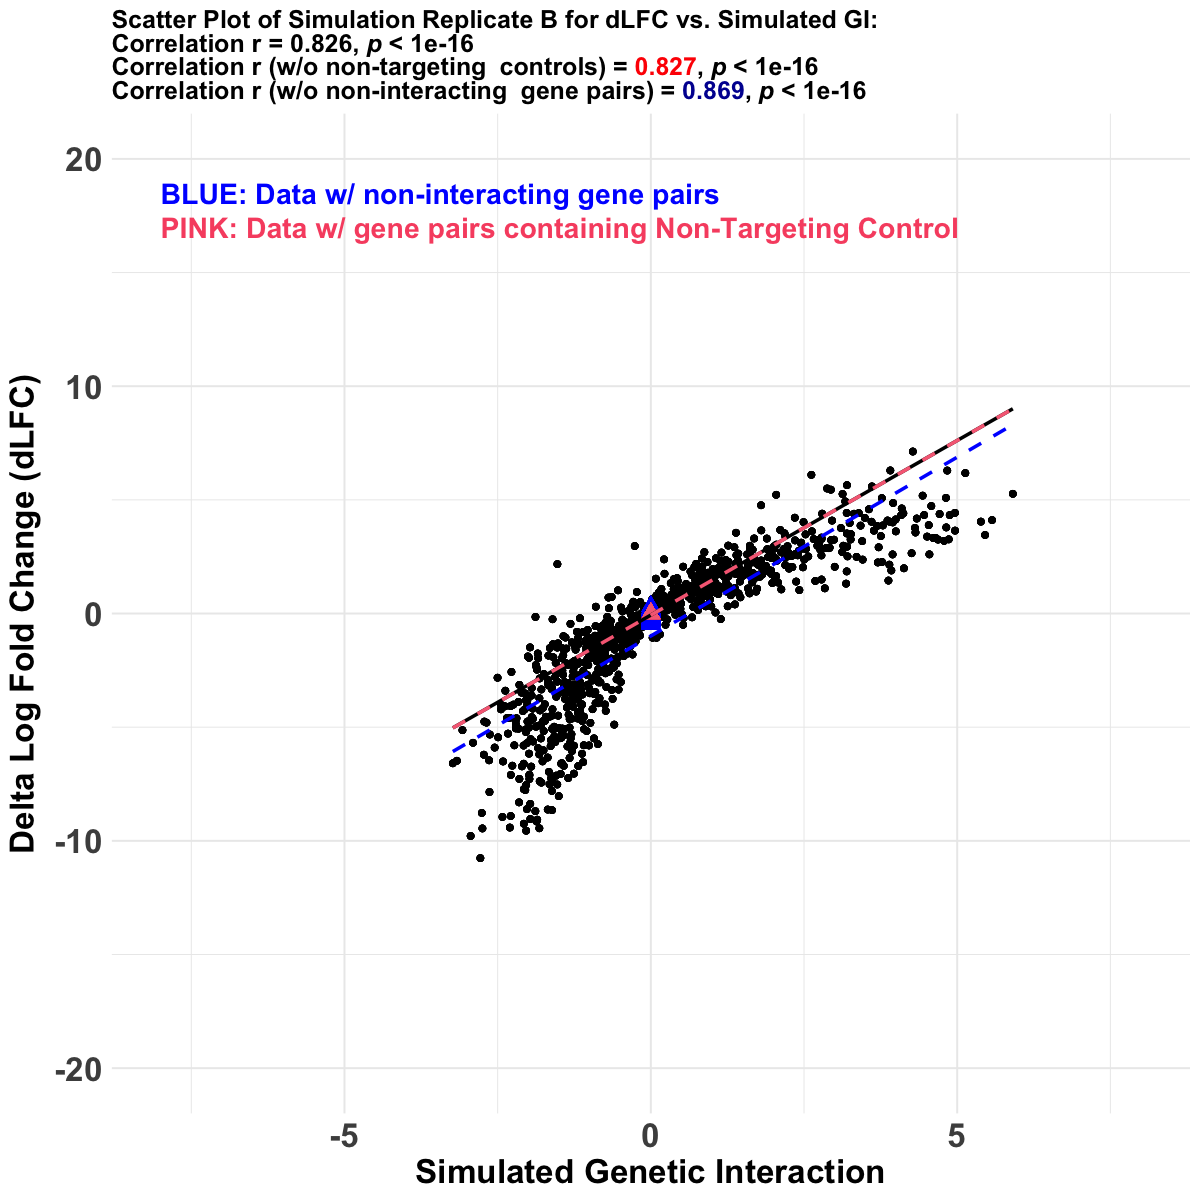

In [43]:
# swtich back to R kernal
library(gemini)
library(readxl)
library(stringr)
library(data.table)
library(parallel)
library(MASS)
library(corrplot)
library(psych)
library(ggtext)
library(tidyverse)
library(dplyr)
library(grid)
library(gridExtra)

# read data from hpc - replicate A only
sample_name = "DKOsim_mimic_fong2024"
pseudo_counts = 5e-9
cell_lib_guide2 = read.csv(paste0("./data/", sample_name, "_", "repB.csv")) %>% 
  dplyr::select(-X) %>% 
  mutate(guide1_type = ifelse(guide1_type == 1, "high", "low"),
         guide2_type = ifelse(guide2_type == 1, "high", "low"),
         construct_type = ifelse(is.na(gene2_behavior), gene1_behavior,
                                 paste0(gene1_behavior, " + ", gene2_behavior)),
         LFC = log2(((rel_freq_guide_t2 + pseudo_counts) / (rel_freq_guide_t0 + pseudo_counts))))


# read the simulated data and prepare sample name
sim_data = cell_lib_guide2 %>%
  mutate(construct_type = ifelse(KO_type == "SKO", "SKO",
                                 ifelse(gene1_behavior == "Non-Targeting Control" | gene2_behavior == "Non-Targeting Control", "SKO", "DKO" )))

nc_gene = unique(as.character(filter(sim_data, gene1_behavior == "Non-Targeting Control")$gene1))

# scatterplot for dLFC vs simulated GIs
xlim = c(-8,8)
ylim = c(-20,20)
# calculate single mutant/knockout fitness
gene_SMF = sim_data %>% 
  filter(construct_type == "SKO", gene1_behavior != "Non-Targeting Control") %>% 
  group_by(gene1) %>% 
  dplyr::summarise(SMF = mean(LFC))
# calculate mean LFC for gene pairs that don't contain control
gene_LFC = sim_data %>% 
  filter(construct_type == "DKO") %>% 
  group_by(gene_pair_id) %>% 
  dplyr::summarise(LFC_mean = mean(LFC))
# calculate dLFC = LFC_mean - (SMF1 + SMF2)
sim_data_dLFC = left_join(sim_data, gene_SMF, by = "gene1") %>% 
  dplyr::rename(gene1_SMF = SMF) %>% 
  left_join(gene_SMF, by = c("gene2"="gene1")) %>% 
  dplyr::rename(gene2_SMF = SMF) %>% 
  left_join(gene_LFC, by = "gene_pair_id") %>% 
  mutate(gene1_SMF = ifelse(is.na(gene1_SMF), 0, gene1_SMF),
         gene2_SMF = ifelse(is.na(gene2_SMF), 0, gene2_SMF),
         LFC_mean = ifelse(construct_type == "SKO",
                           ifelse(gene1_SMF == 0, gene2_SMF, gene1_SMF), LFC_mean)) %>% 
  mutate(dLFC = LFC_mean - (gene1_SMF+gene2_SMF))

# add data frame for the non-control group
control = sim_data_dLFC %>% filter(gene1 %in% nc_gene | gene2 %in% nc_gene)
sim_dLFC_noncontrol = sim_data_dLFC %>% anti_join(control, by = "gene1_gene2_id")
# add data frame for the non-interacting group
control0 = sim_data_dLFC %>% filter(interaction_gene == 0)
sim_dLFC_noncontrol0 = sim_data_dLFC %>% anti_join(control0, by = "gene1_gene2_id")

# compute correlation and p-values
cor_test_all <- cor.test(sim_data_dLFC$interaction_gene, sim_data_dLFC$dLFC, method = "pearson")
cor_test_noncontrol <- cor.test(sim_dLFC_noncontrol$interaction_gene, sim_dLFC_noncontrol$dLFC, method = "pearson")
cor_test_noncontrol0 <- cor.test(sim_dLFC_noncontrol0$interaction_gene, sim_dLFC_noncontrol0$dLFC, method = "pearson")
# define a function to format p-values if p-values are extremely small
format_p <- function(pval) {
  if (is.na(pval)) return("NA")
  if (pval < 1e-16) {
    return("< 1e-16")
  } else {
    return(formatC(pval, format = "e", digits = 2))
  }
}
# plot the scatterplot
theme_text = theme(
  plot.title = element_markdown(size = 15, face = "bold"),   # Title size, add 'face = "bold"' if needed'
  axis.title.x = element_text(size = 20, face = "bold"),  # X-axis title
  axis.title.y = element_text(size = 20, face = "bold"),  # Y-axis title
  axis.text.x = element_text(size = 20, face = "bold"),   # X-axis text
  axis.text.y = element_text(size = 20, face = "bold"),   # Y-axis text
  legend.title = element_text(size = 20),  # Legend title
  legend.text = element_text(size = 20),   # Legend text
  strip.text = element_text(size = 30)     # Facet labels
)
scatterplot_dlfc = ggplot(sim_data_dLFC, aes(x = interaction_gene, y = dLFC)) +
  geom_point(alpha = 0.7, color = "black") +
  geom_point(data = control0, aes(x = interaction_gene, y = dLFC), 
             size = 3, shape = 17, color = "blue", fill = "yellow", stroke = 1.5) +
  geom_point(data = control, aes(x = interaction_gene, y = dLFC), 
             size = 3, shape = 17, color = "#f76d84", fill = "yellow", stroke = 1.5) +
  # Regression line for all data
  geom_smooth(method = "lm", col = "black", se = FALSE, linetype = "solid") + 
  # Regression line for non-control data
  geom_smooth(data = sim_dLFC_noncontrol, aes(x = interaction_gene, y = dLFC), 
              method = "lm", col = "#f76d84", se = FALSE, linetype = "dashed") + 
  # Regression line for non-zero genetic interactions data
  geom_smooth(data = sim_dLFC_noncontrol0, aes(x = interaction_gene, y = dLFC), 
              method = "lm", col = "blue", se = FALSE, linetype = "dashed") + 
  ggtitle(paste0(
  "Scatter Plot of Simulation Replicate B for dLFC vs. Simulated GI:<br>",
  "Correlation r = ", round(cor_test_all$estimate, 3), 
  ", *p* ", format_p(cor_test_all$p.value), "<br>",
  "Correlation r (w/o non-targeting  controls) = <span style='color:red;'>", round(cor_test_noncontrol$estimate, 3),
  "</span>, *p* ", format_p(cor_test_noncontrol$p.value), "<br>",
  "Correlation r (w/o non-interacting  gene pairs) = <span style='color:#0404a0;'>", round(cor_test_noncontrol0$estimate, 3), 
  "</span>, *p* ", format_p(cor_test_noncontrol0$p.value))) +
  labs(color = "Gene-gene Interaction Type") +
  guides(color = guide_legend(override.aes = list(size = 5))) +
  ylim(ylim[1],ylim[2])+
  xlim(xlim[1],xlim[2])+
  theme_minimal() +
  xlab("Simulated Genetic Interaction") +
  ylab("Delta Log Fold Change (dLFC)") +
  # Add annotation label for control points
  annotate("text", x = xlim[1], 
           y = ylim[2]-3, 
           label = "PINK: Data w/ gene pairs containing Non-Targeting Control", 
           color = "#f85470", size = 6, hjust = 0, fontface = "bold") +
  # Add annotation label for non-interacting points
  annotate("text", x = xlim[1], 
           y = ylim[2]-1.5, 
           label = "BLUE: Data w/ non-interacting gene pairs", 
           color = "blue", size = 6, hjust = 0, fontface = "bold")  +
  theme_text

# show the plot
options(repr.plot.width = 10, repr.plot.height = 10)
scatterplot_dlfc